# Proyecto: Evaluación del riesgo crediticio para Banco Alemán

## Importación de librerías

In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency,chi2,pointbiserialr
import scipy.stats as stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
from time import time
from collections import Counter
from sklearn.tree import plot_tree

# Preprocesado y modelado
# ==============================================================================
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import statsmodels.formula.api as smf
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,binarize,MinMaxScaler,RobustScaler,Binarizer
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_validate,GridSearchCV,RandomizedSearchCV, RepeatedStratifiedKFold,KFold

# Metricas
# ==============================================================================
from sklearn.feature_selection import mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc,classification_report,confusion_matrix,f1_score


# Modelos
# ==============================================================================
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors  import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

# Optimizacion
# ==============================================================================
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')
import os


## Descripción del dataset

El data set cuenta con nueve variables explicativas de la variable "target", es decir, la variable la cual queremos que nuestro modelo prediga, que en este caso es "Risk". En resumen, queremos predecir si las distintas solicitudes de crédito, seran o no riesgosas. 

VARIABLES:
- Age (numérica)
- Sex (texto: male, female)
- Job (numérica: 0 - no calificado y no residente, 1 - no calificado y residente, 2 - calificado, 3 - altamente calificado)
- Housing (texto: own, rent, or free)
- Saving accounts (texto - little, moderate, quite rich, rich)
- Checking account (texto - little, moderate, rich)
- Credit amount (numérica en euros)
- Duration (numérica, en meses)
- Purpose (texto: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
- Risk (categorica: good,bad) 

Fuente: https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk

## Objetivo del modelo

Exploraremos el comportamiento de las variables de los clientes del banco alemán al momento de pedir un crédito, donde buscaremos responder preguntas como:
- ¿Con qué propósito solicitan los clientes crédito en el banco?
- ¿Qué patrones determinan si el préstamo tendrá un buen o mal riesgo?
- ¿Quienes son los que piden préstamos (edad, sexo, que trabajo tienen, etc)?

Objetivo de Análisis:

Minimizar la pérdida desde la perspectiva del banco, el banco necesita una regla de decisión con respecto a quién aprobar el préstamo y quién no (sección "Planteo de métricas" para mas detalle). Dada la perspectiva del negocio, realizaremos un análisis de los datos de muestra en pos de encontrar patrones que nos ayuden a determinar si un crédito podria ser de alto o bajo riesgo.

## Análisis Inicial 

In [3]:
#DEFINICIÓN DE FUNCIONES

# Función de ayuda para verificar los valores p contra un nivel alfa e imprimir el resultado
def check_p_val(p_val, alpha):

    if p_val < alpha:
        print('Tenemos evidencia para rechazar la hipótesis nula')
    else:
        print('No tenemos evidencia para rechazar la hipótesis nula')
        
# función creada por mi para traer los NA's
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

# Función para gráfico de torta
def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')
    
# Función para un data frame que especifica la frecuencia absoluta y relativa de una variable (columna) x que tiene que ir entre comillas. Ejemplo, para la variable purpose, poner x = 'Purpose'
def frc(x):
    frec = df[x].value_counts()  
    frec_df = pd.DataFrame(frec)
    frec_df.rename(columns={x:'Frec_abs'},inplace=True)   

    #Obtenemos los valores de las Frecuencias Absolutas
    Frec_abs_val = frec_df["Frec_abs"].values

    #Creamos una lista vacia en donde vamos a guardar las frecuencias absolutas acumuladas
    acum = []

    #Iniciamos una variable en la que guardaremos los valores anteriores
    valor_acum = 0

    #Recorremos la lista  de las frecuencias absolutas para irlas sumando
    for i in Frec_abs_val:
        valor_acum = valor_acum + i
        acum.append(valor_acum)

    frec_df["frec_abs_acum"] = acum

    # Se ordenan los  valores de mayor a menor y se hace el acumulado
    #Calculamos la Frecuencia Relativa en %
    frec_df["frec_rel_%"] = 100 * frec_df["Frec_abs"]/len(df[x])
    frec_df
    #Obtenemos los valores de las Frecuencias Relativas
    Frec_rel_val = frec_df["frec_rel_%"].values

    #Creamos una lista vacia en donde vamos a guardar las frecuencias relativas acumuladas
    acum = []

    #Iniciamos una variable  en la que guardaremos los valores anteriores
    valor_acum = 0

    #Recorremos la lista  de las frecuencias relativas para irlas sumando
    for i in Frec_rel_val:
        valor_acum = valor_acum + i
        acum.append(valor_acum)

    frec_df["frec_rel_%_acum"] = acum
    return(frec_df)

### Adquisición de Datos

In [4]:
os.chdir(os.getcwd())

In [5]:
#Lectura DataSet

df = pd.read_csv('german_credit_data.csv', sep = ',',index_col="Unnamed: 0")
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [12]:
#Tamaño del data set
df.shape

(1000, 10)

In [13]:
#Información adicional sobre tipos de variables que tenemos y la cantidad de registros por columna
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 85.9+ KB


In [14]:
# Vemos las variables de nuestras categóricas 
unique_housing = df['Housing'].unique()
unique_purpose = df['Purpose'].unique()
unique_savings = df['Saving accounts'].unique()
unique_checking = df['Checking account'].unique()
print(unique_housing)
print(unique_purpose)
print(unique_savings)
print(unique_checking)

['own' 'free' 'rent']
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
[nan 'little' 'quite rich' 'rich' 'moderate']
['little' 'moderate' nan 'rich']


## Data Wrangling 

In [15]:
#Tipos de datos
df.dtypes

Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object

In [6]:
get_na(df)

,datos sin NAs en q,Na en q,Na en %
Checking account,606,394,39.4
Saving accounts,817,183,18.3
Age,1000,0,0.0
Sex,1000,0,0.0
Job,1000,0,0.0
Housing,1000,0,0.0
Credit amount,1000,0,0.0
Duration,1000,0,0.0
Purpose,1000,0,0.0
Risk,1000,0,0.0


In [7]:
df["Saving accounts"].fillna("No",inplace=True)
df["Checking account"].fillna("No",inplace=True)
df.head(5)
# Reemplazamos los NaN por 'No' para Checking y Savings accounts ya que interpretamos que se pusieron valores nulos porque no poseian el tipo de 
# cuenta de la columna 

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,No,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,No,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [8]:
# Comprobamos que ya no tenemos NaN
get_na(df)

,datos sin NAs en q,Na en q,Na en %
Age,1000,0,0.0
Sex,1000,0,0.0
Job,1000,0,0.0
Housing,1000,0,0.0
Saving accounts,1000,0,0.0
Checking account,1000,0,0.0
Credit amount,1000,0,0.0
Duration,1000,0,0.0
Purpose,1000,0,0.0
Risk,1000,0,0.0


## Análisis de las variables

### Análisis Univariado

In [19]:
#Nombre de las variables
df.columns

Index(['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account',
       'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')

In [20]:
#Medidas Estadisticas de Tendencia Central
df.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


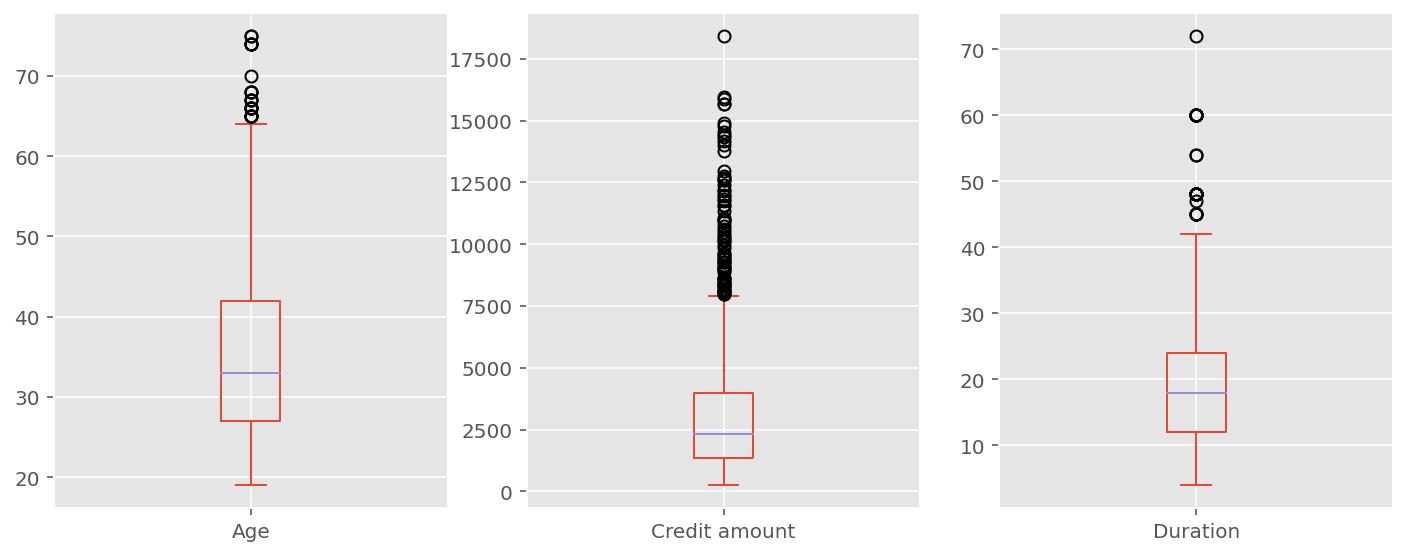

In [21]:
df[['Age','Credit amount','Duration']].plot(kind= 'box' , subplots=True, layout=(2,3), sharex=False, sharey=False, figsize=(12,10));

###### Resumen de los datos:

- No podemos tener en cuenta la media como representativa porque los datos tiene un % grande de desviación estandar respecto a ella 
- Credit Amount tiene muchos valores outliers que podemos ver en el grafico y ademas vemos que el 75% de los creditos son de hasta 4000 euros
- En duration el 75% de los creditos son de hasta 24 meses, con un maximo de 72m.
- En Age, el 50% de las personas tienen entre 27 y 42 años , y no presenta demasiados outliers 

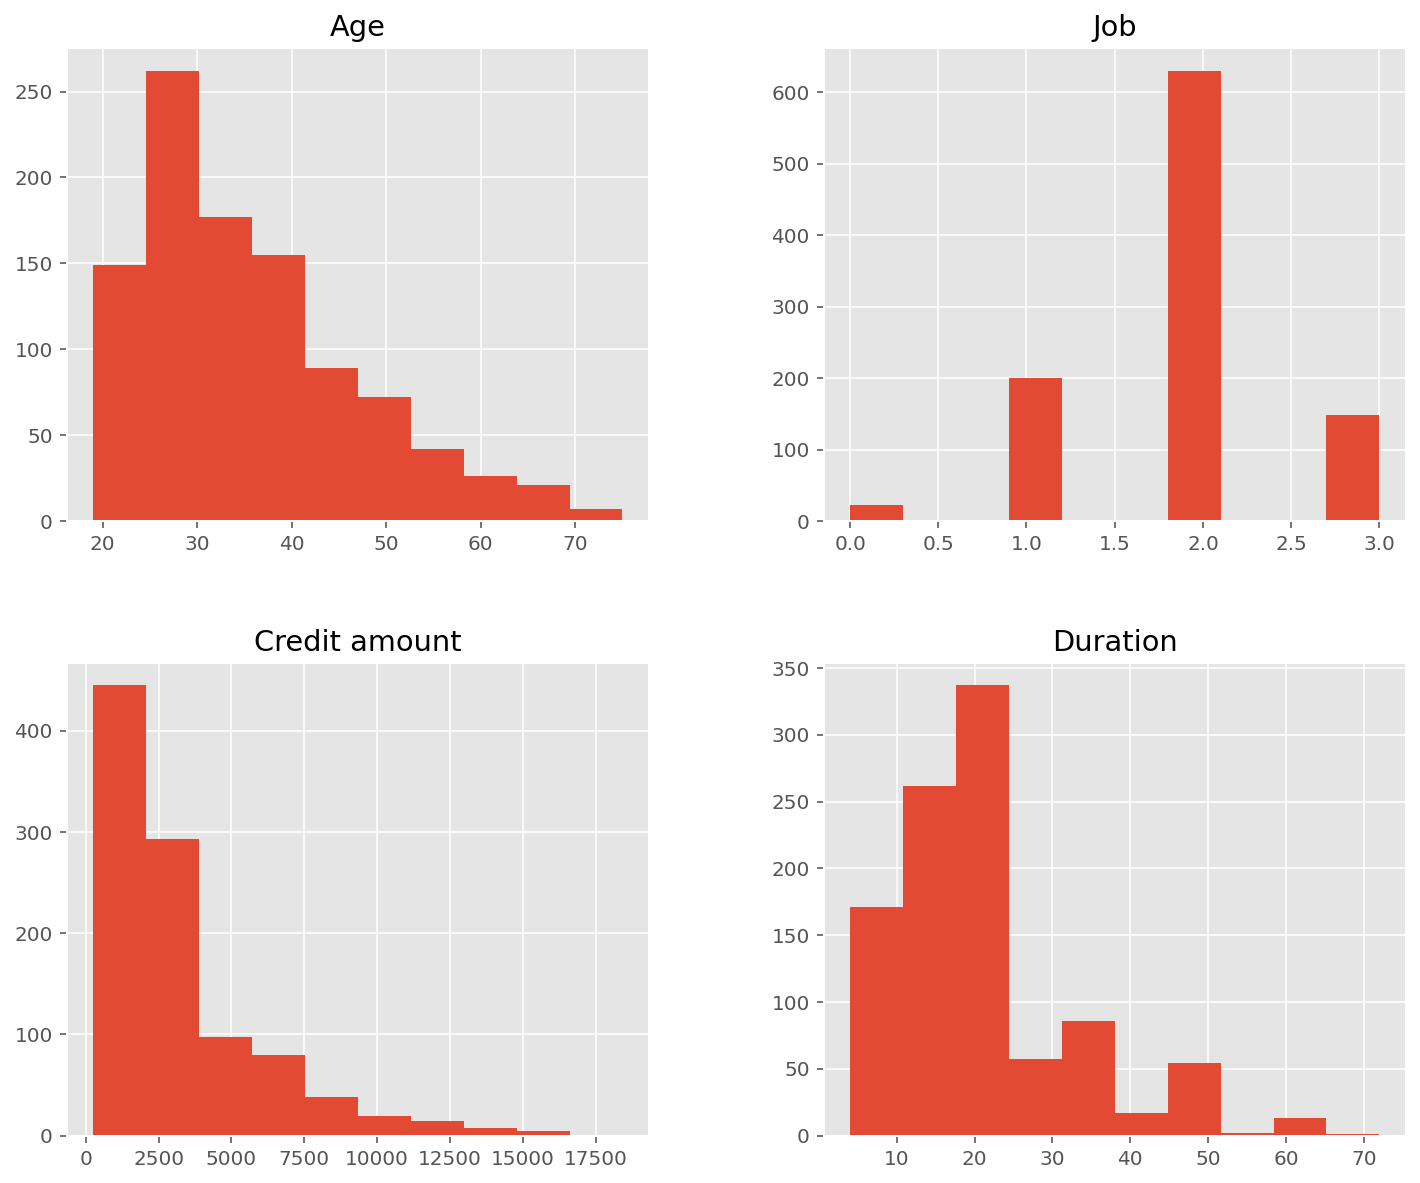

In [22]:
# Analizo como se distribuye cada una de ellas --> la categórica de job unicamente nos sirve para ver
# cual es mas frecuente 

X = df.dropna().loc[:, df.columns != 'Risk'] 
# en las x dejo las variables explicativas y dejo el outcome en la variable y 
y = df.dropna().Risk.values.ravel()  
X.hist(figsize=(12,10));

###### Conclusión del análisis:

- Podemos ver que los que mas piden prestamos son los que tienen trabajos de tipo 2 : Calificado
- Las edades con un pico de frecuencia son entre los 25 y 30 años, estos son los mas probables a la hora de pedir un credito.
- El 63% de los trabajos son de tipo 2 (Calificado) y el 83% de los datos de trabajo los acumulan los de tipo 2 y 1 (No calificado y residente)
- Gran parte de los creditos son repagados a los 20-25 meses de su otorgamiento.

#### Variables Categóricas

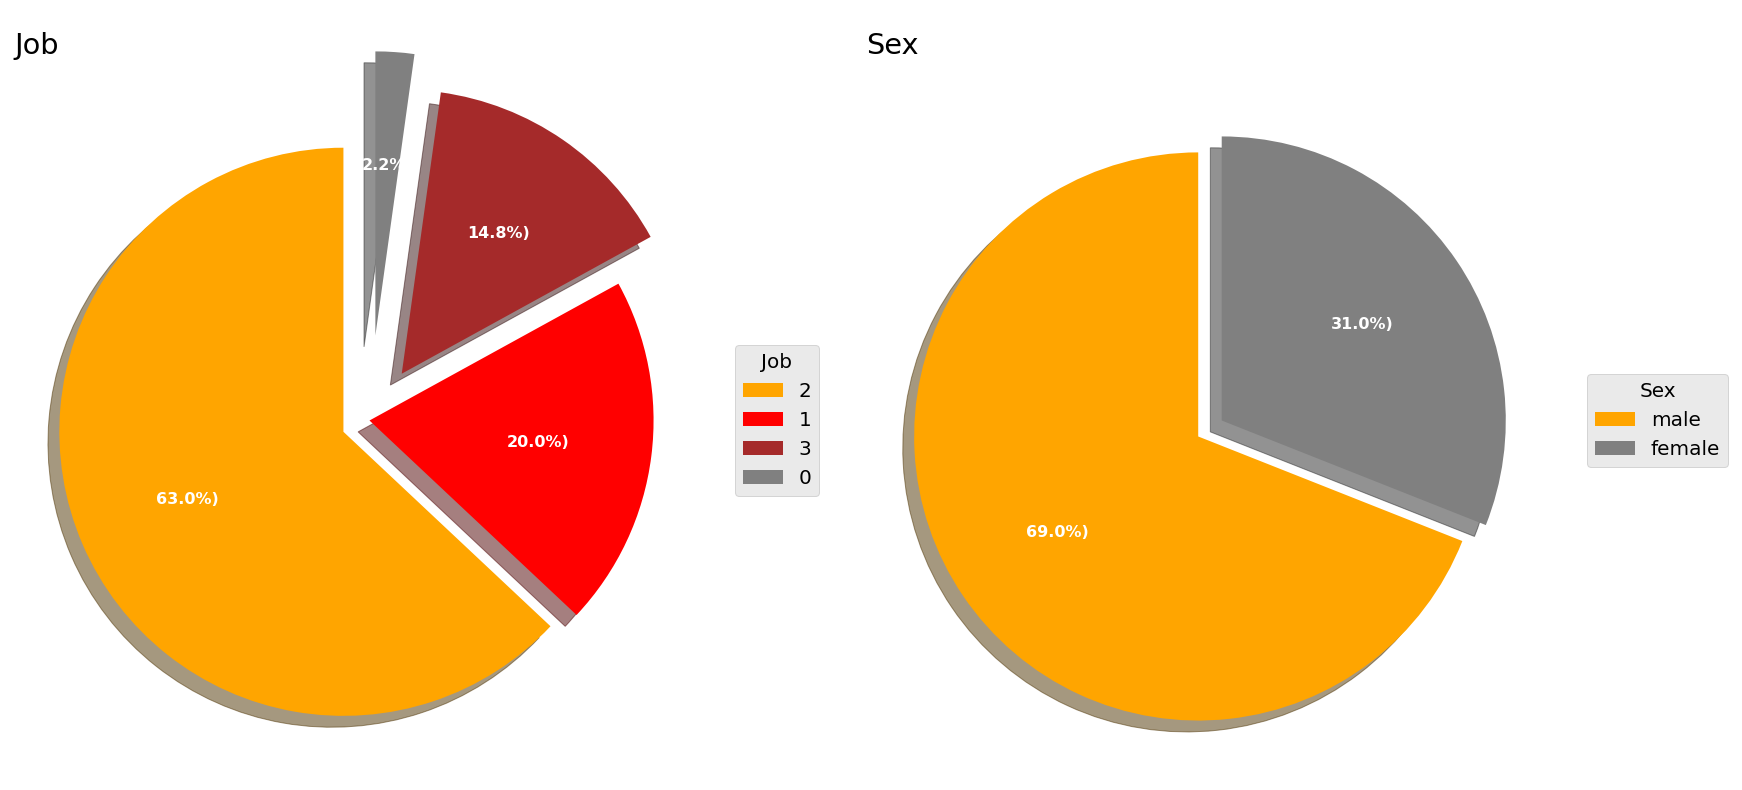

In [23]:
# Genero gráficos de torta 

def contar_parametros(df):
    aux1=[0,0,0,0]
    for i in df:
        if i == 2:
            aux1[0] = aux1[0] +1 
        elif i == 1:
            aux1[1] = aux1[1] +1
        elif i == 3:
            aux1[2] = aux1[2] +1 
        else:
            aux1[3]= aux1[3] +1
    return(aux1)

#Separa los triángulos de la torta
explode = (0.1, 0.0, 0.2, 0.3)
data = (690,310)
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%)".format(pct, absolute,)
fig, ax = plt.subplots(1, 2, figsize=(14, 10))
fig.set_facecolor('white')
wedges, texts, autotexts = ax[0].pie(x = contar_parametros(df['Job']),labels = df['Job'].unique(),
         autopct = lambda pct: func(pct, df['Job']),
        explode = explode,
        colors = ( "orange", "red", "brown","grey"),
       shadow = True,
        startangle = 90,
        textprops = dict(color ="white"));
# Adding legend
ax[0].legend(wedges, df['Job'].unique(),
          title ="Job",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autotexts, size = 8, weight ="bold")
ax[0].set_title("Job",loc ="left",color='black')
#--------------------------------------------------------------------------------------#
wedges, texts, autotexts = ax[1].pie(x = data,labels = df['Sex'].unique(),
        autopct = lambda pct: func(pct, df['Job']),
        explode = (0.1, 0.0),
        colors = ( "orange","grey"),
       shadow = True,
        startangle = 90,
        textprops = dict(color ="white"));
# Adding legend
ax[1].legend(wedges, df['Sex'].unique(),
          title ="Sex",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.setp(autotexts, size = 8, weight ="bold")
ax[1].set_title("Sex",loc ="left",color='black')
# show plot
plt.show()

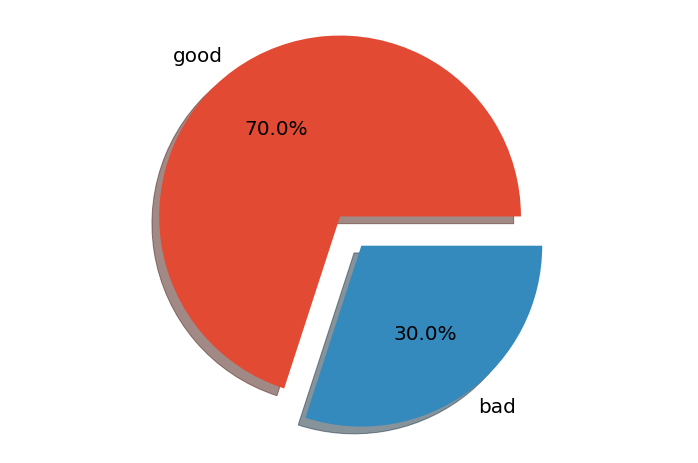

In [24]:
# Analizo como se comporta la variable target 
plot_pie(df.Risk)

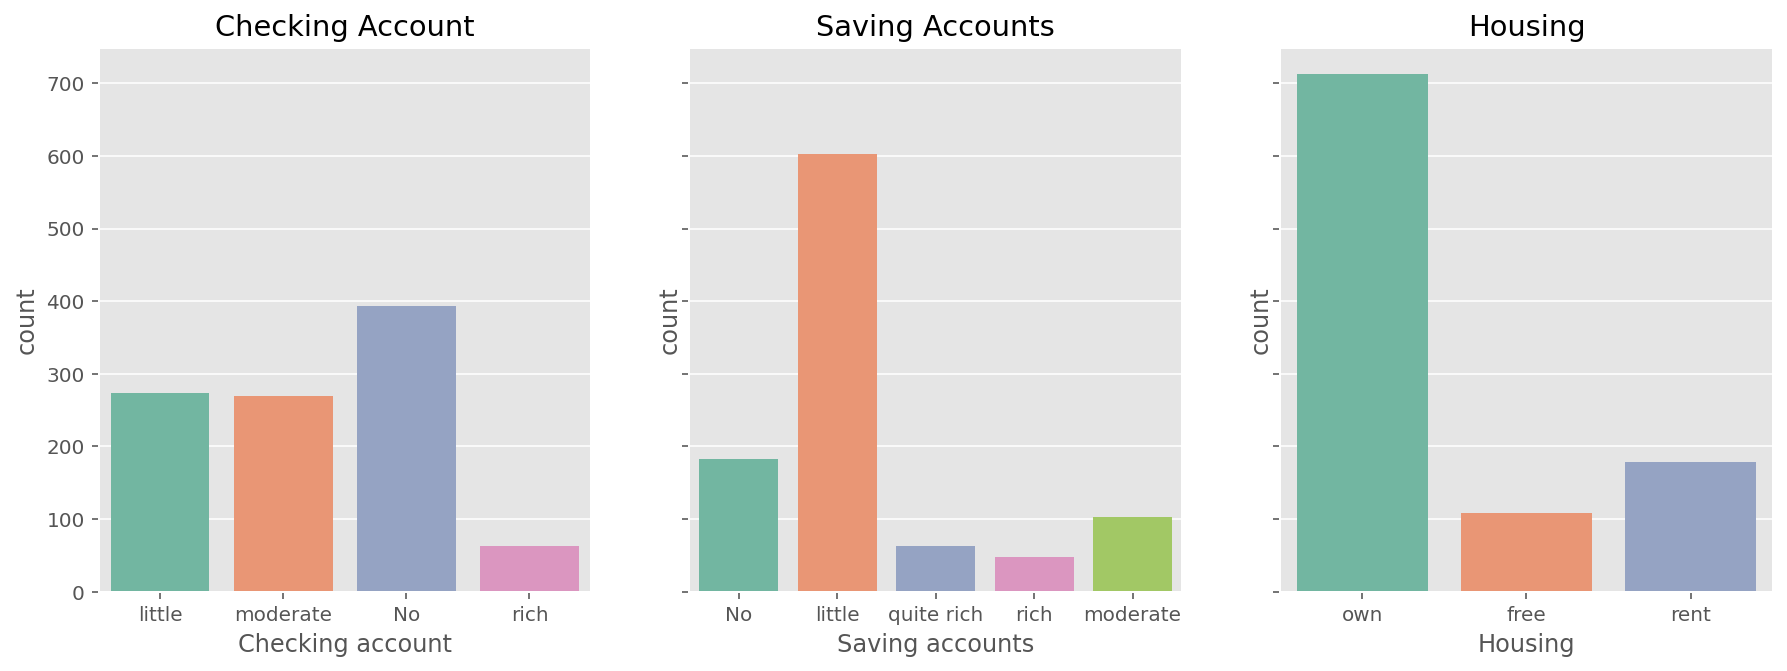

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5),sharey = True)
fig.set_facecolor('white')
sns.countplot(x=df['Checking account'],ax=ax[0],palette="Set2",linewidth=1)
sns.countplot(x=df['Saving accounts'],ax=ax[1],palette="Set2",linewidth=1)
sns.countplot(x=df['Housing'],ax=ax[2],palette="Set2",linewidth=1)
ax[0].set_title("Checking Account",color='black')
ax[1].set_title("Saving Accounts",color='black')
ax[2].set_title("Housing",color='black')

plt.show();

In [26]:
# HACEMOS ANÁLISIS DE FRECUENCIAS DE LOS DATOS PERO AHORA DE FORMA ANALITICA 
x = 'Checking account'
frc(x)
# Vemos que el 40% de los datos los ocupa la variable "No"que son los que no tienen checking account 
# y un 30% de frecuencia tienen las de poco monto (apenas por encima de los moderados)

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
No,394,394,39.4,39.4
little,274,668,27.4,66.8
moderate,269,937,26.9,93.7
rich,63,1000,6.3,100.0


In [27]:
x = 'Purpose'
frc(x)
#el 34% son "Car", y ya con las primeras tres variables acumulamos el 80% de los datos muestrales 

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
car,337,337,33.7,33.7
radio/TV,280,617,28.0,61.7
furniture/equipment,181,798,18.1,79.8
business,97,895,9.7,89.5
education,59,954,5.9,95.4
repairs,22,976,2.2,97.6
domestic appliances,12,988,1.2,98.8
vacation/others,12,1000,1.2,100.0


In [28]:
x = 'Housing'
frc(x)
# el 70% son clientes con casa propia, muy diferenciado del resto de las variables 

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
own,713,713,71.3,71.3
rent,179,892,17.9,89.2
free,108,1000,10.8,100.0


In [29]:
x = 'Saving accounts'
frc(x)
# La mayoria de los clientes tienen caja de ahorro con bajos montos. Los segundos mas frecuentes son los que no tienen caja 
# de ahorro 

,Frec_abs,frec_abs_acum,frec_rel_%,frec_rel_%_acum
little,603,603,60.3,60.3
No,183,786,18.3,78.6
moderate,103,889,10.3,88.9
quite rich,63,952,6.3,95.2
rich,48,1000,4.8,100.0


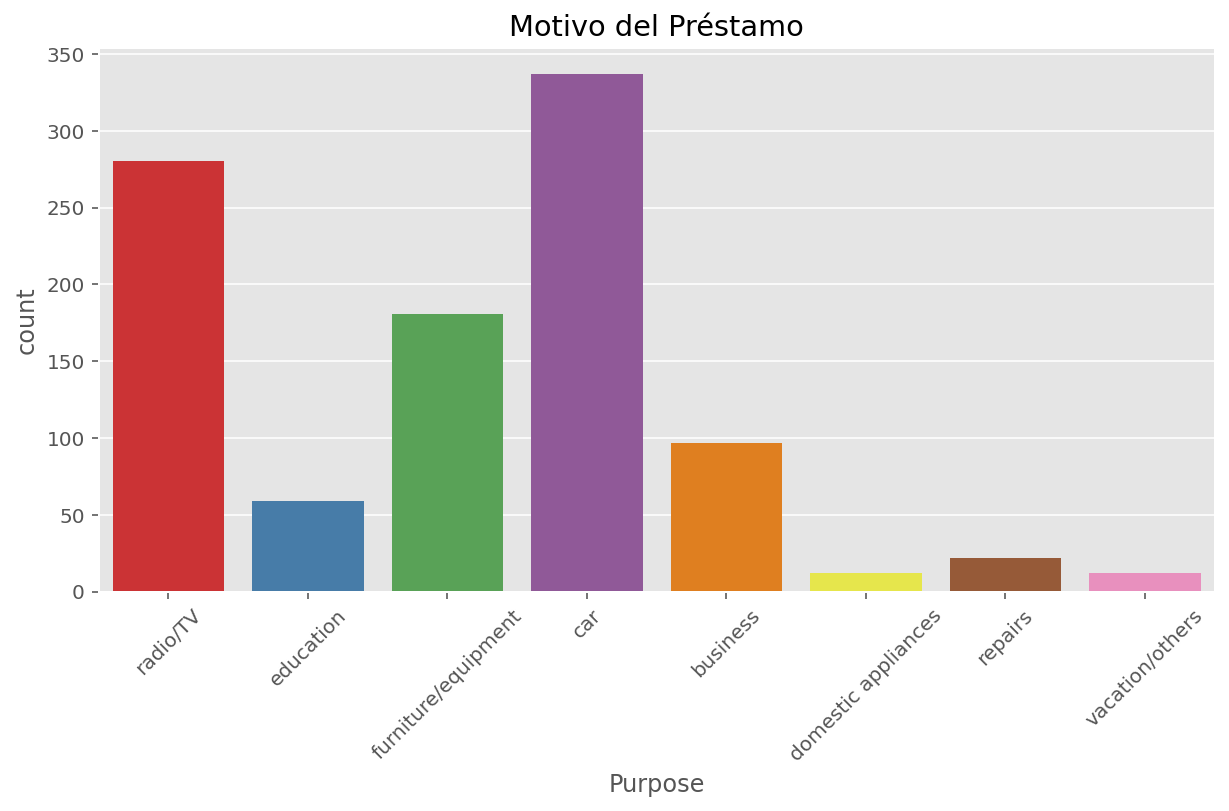

In [30]:
fig, ax = plt.subplots( figsize=(10, 5))
fig.set_facecolor('white')
sns.countplot(x=df['Purpose'],palette="Set1",linewidth=1)
ax.set_title("Motivo del Préstamo",color='black')
ax.set_xticklabels(labels=df['Purpose'].unique(),rotation=45)
plt.show()

###### Resumen de los datos:

- Target --> vemos que tenemos mucho mas frecuencia de buenos créditos, tendremos que balancear esta variable
- Checking account --> vemos que la mayoria no tiene cuentas de cheque y de los que sí tienen cuenta, tenemos iguales cantidad de leves y moderados, y tenemos mucha menos frecuencia en rich
- Saving accounts --> gran diferencia entre las saving account de bajo monto en relacion al resto de las categorias 
- Motivo de prestamo --> la mas frecuente es para auto y le sigue para radio/tv (ambas se diferencian bastante del resto)
- Housing --> gran diferencia de frecuencias, la mayoria de la muestra tienen casa propia 

## ANÁLISIS BIVARIADO Y MULTIVARIADO 

## Análisis de la variable "AGE"

Generamos una clasificación categórica de las edades y queremos responder las siguientes preguntas:

- Existe alguna diferenciación por edades de los créditos otorgados? 
- Hay algun grupo de personas que tengan una clara diferenciación de riesgos en los créditos que tuvo?
- Estos grupos de personas, tienen motivos distintos por los cuales piden créditos?
- Realmente hay grupos de edades que son mas riesgosos que otros?

### Clasificación de los grupos de edades

- Student (18 - 25 años) \ Young (25 - 35 años) \ Adult (35 - 60 años) \ Senior ( +60 años)

### Conclusiones

- Podemos ver que son muchos mas los Young y Adult que piden créditos en comparación con los Senior y Student 
- Viendo las variaciones que tiene cada categoria entre los riesgos, vemos que hay una gran diferencia de riesgos intragrupal de Young y Adult. Por que se puede dar que en un mismo rango de edades varien tanto sus riesgos?
- Podemos ver que hay una clara relación, para los grupos de Adult y Senior, entre monto de crédito y cuan riesgoso es. Vemos que los montos mas grandes de crédito son créditos de alto riesgo para estos grupos.


In [9]:
# Generamos una clasificación categórica de las edades
# Aclaración: Student no quiere decir que la persona este estudiando sino que esta en edad donde "generalmente" se realizan los estudios universitarios
intervalo = (18, 25, 35, 60, 120)

categorias = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, intervalo, labels=categorias)
df = df.iloc[:,1:11]
df.head()

,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat
0,male,2,own,No,little,1169,6,radio/TV,good,Senior
1,female,2,own,little,moderate,5951,48,radio/TV,bad,Student
2,male,1,own,little,No,2096,12,education,good,Adult
3,male,2,free,little,little,7882,42,furniture/equipment,good,Adult
4,male,2,free,little,little,4870,24,car,bad,Adult


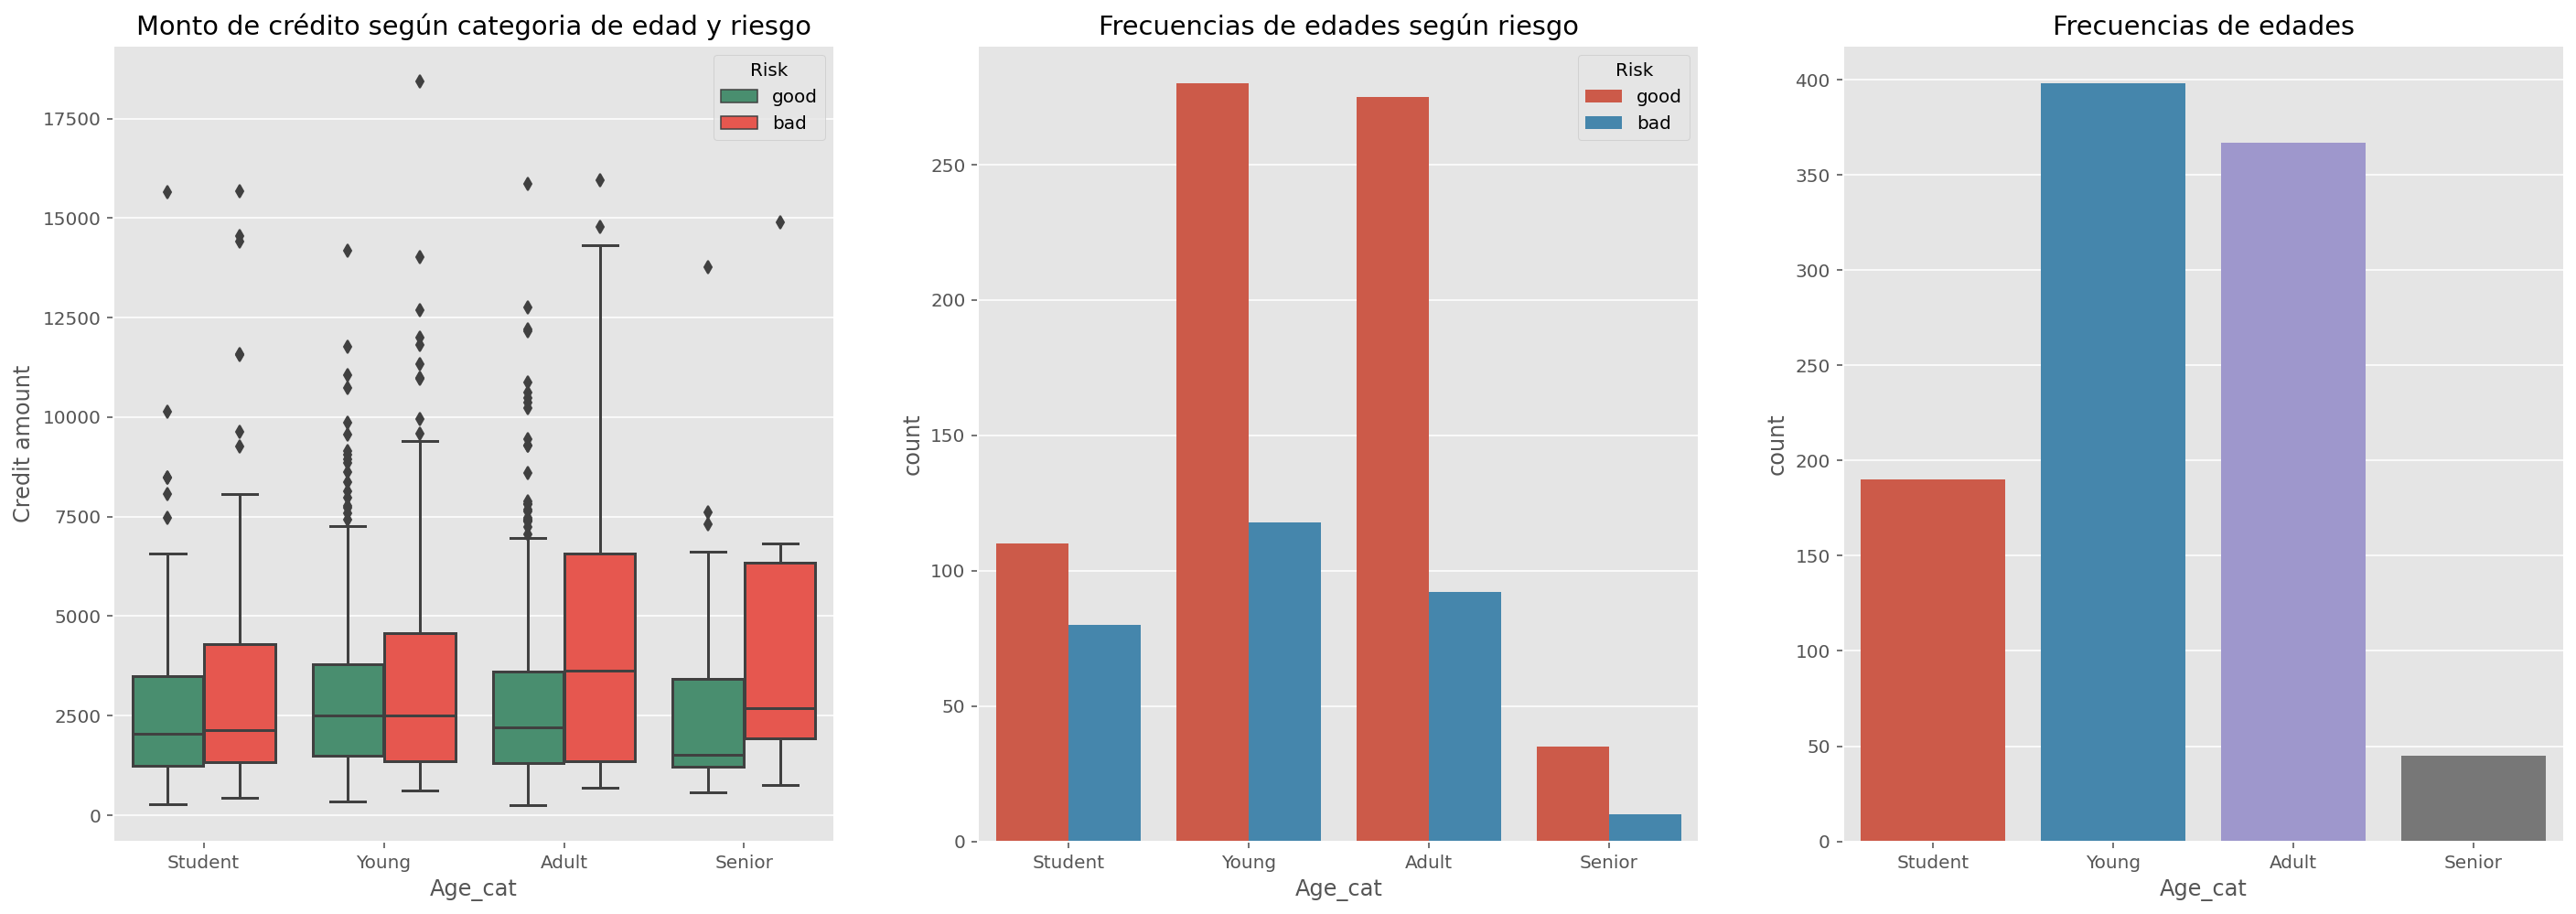

In [32]:

fig, ax = plt.subplots(1, 3, figsize=(24,8))

sns.boxplot(x="Age_cat",y='Credit amount',data=df,hue='Risk', ax=ax[0],palette=['#3D9970','#FF4136'])
ax[0].set_title("Monto de crédito según categoria de edad y riesgo")

sns.countplot(x="Age_cat",data=df,hue = "Risk", dodge=True, ax = ax[1])
ax[1].set_title("Frecuencias de edades según riesgo")

sns.countplot(x="Age_cat",data=df, dodge=True, ax = ax[2])
ax[2].set_title("Frecuencias de edades")

plt.show()


----------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Análisis por Variable "SEX"

- Hay alguna variación significativa en los riesgos si cambia la variable "sex"? 
- Hombres y mujeres piden créditos para los mismos propósitos? 
- Son ambos rentables a nivel riesgo para el banco? 

### Conclusión: 

Eliminamos la variable sex del modelo porque no aporta informacion acerca de la variable target y suele no estar permitida en los análisis crediticios.

- La distribución de la variable sex según el riesgo, es la misma para credit amount y duration.
- En proporsión los hombres y las mujeres piden creditos por los mismos propósitos
- No hay un sexo que sea significativamente mas riesgoso que el otro.
- Los mayoria de los créditos son por debajo de los 5000 euros.
- Para los créditos mayores a 5000 euros, es mas probable que sean calificados como riesgosos. 
- Los Senior y Adult con con créditos mayores a 5000 tienen mayor probabilidad de ser clasificados riesgosos.
- Los Student y Young son los que piden créditos de menor monto (en gral. por debajo de 5000 euros)
- Contamos con mayor proporción de Young y Adult.


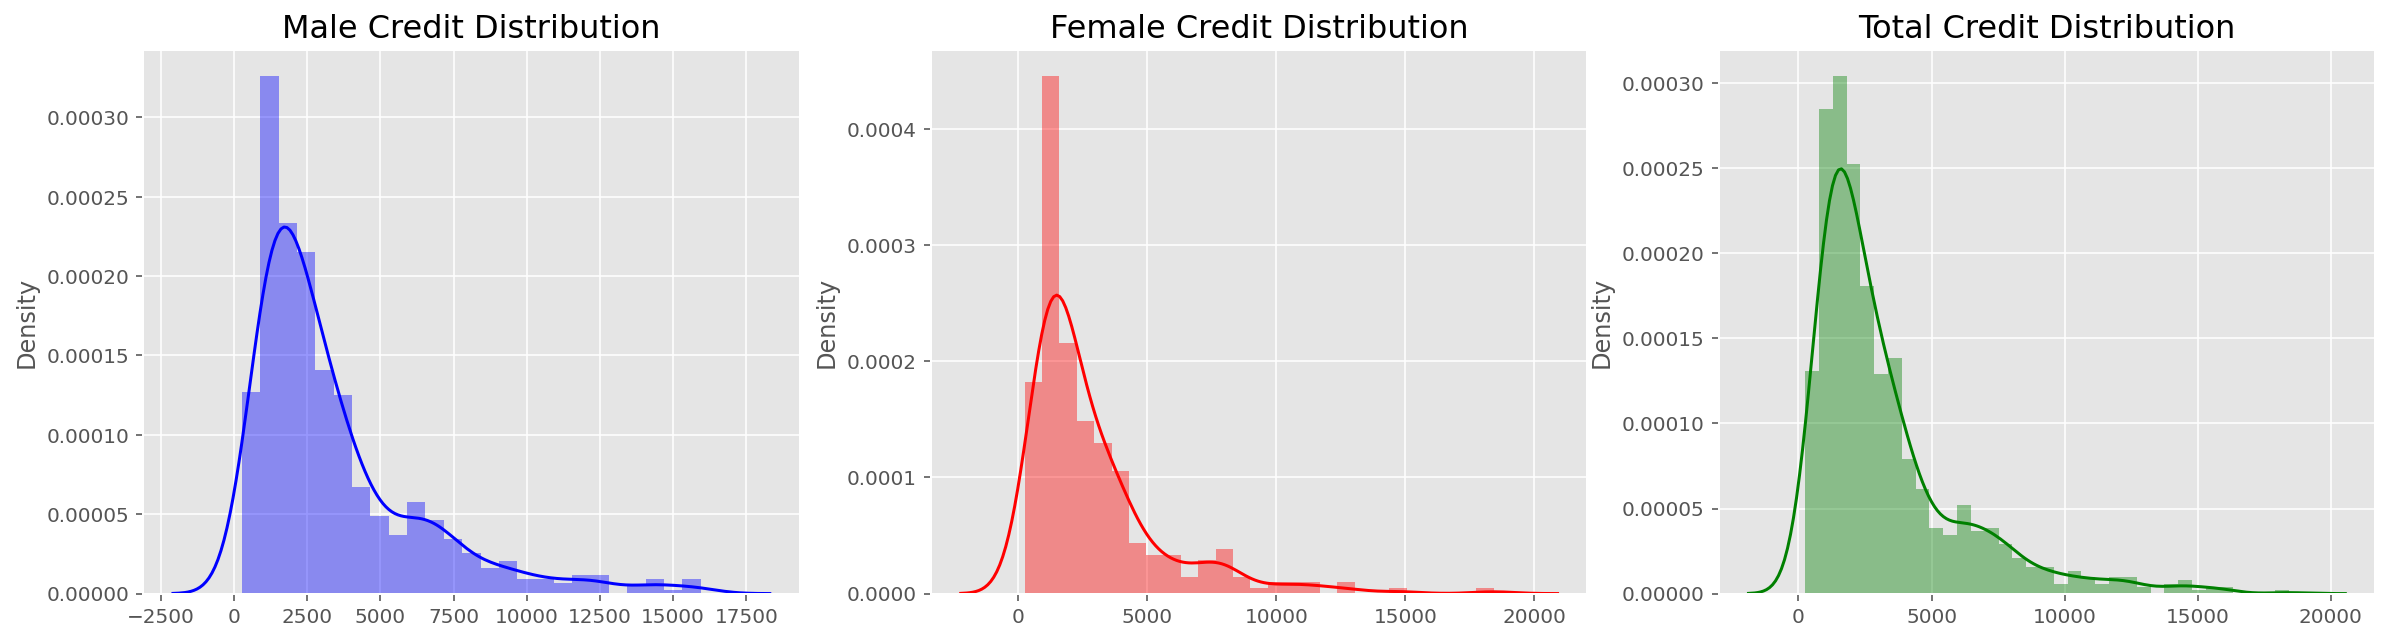

In [33]:
male_credit = df["Credit amount"].loc[df["Sex"] == "male"].values
female_credit = df["Credit amount"].loc[df["Sex"] == "female"].values
total_credit = df['Credit amount'].values

fig, ax = plt.subplots(1, 3, figsize=(20,5))

sns.distplot(male_credit, ax=ax[0], color="b")
ax[0].set_title("Male Credit Distribution", fontsize=16)
sns.distplot(female_credit, ax=ax[1], color="r")
ax[1].set_title("Female Credit Distribution", fontsize=16)
sns.distplot(total_credit, ax=ax[2], color="g")
ax[2].set_title("Total Credit Distribution", fontsize=16)
plt.show()

Text(0.5, 1.0, 'Propósitos por sexo')

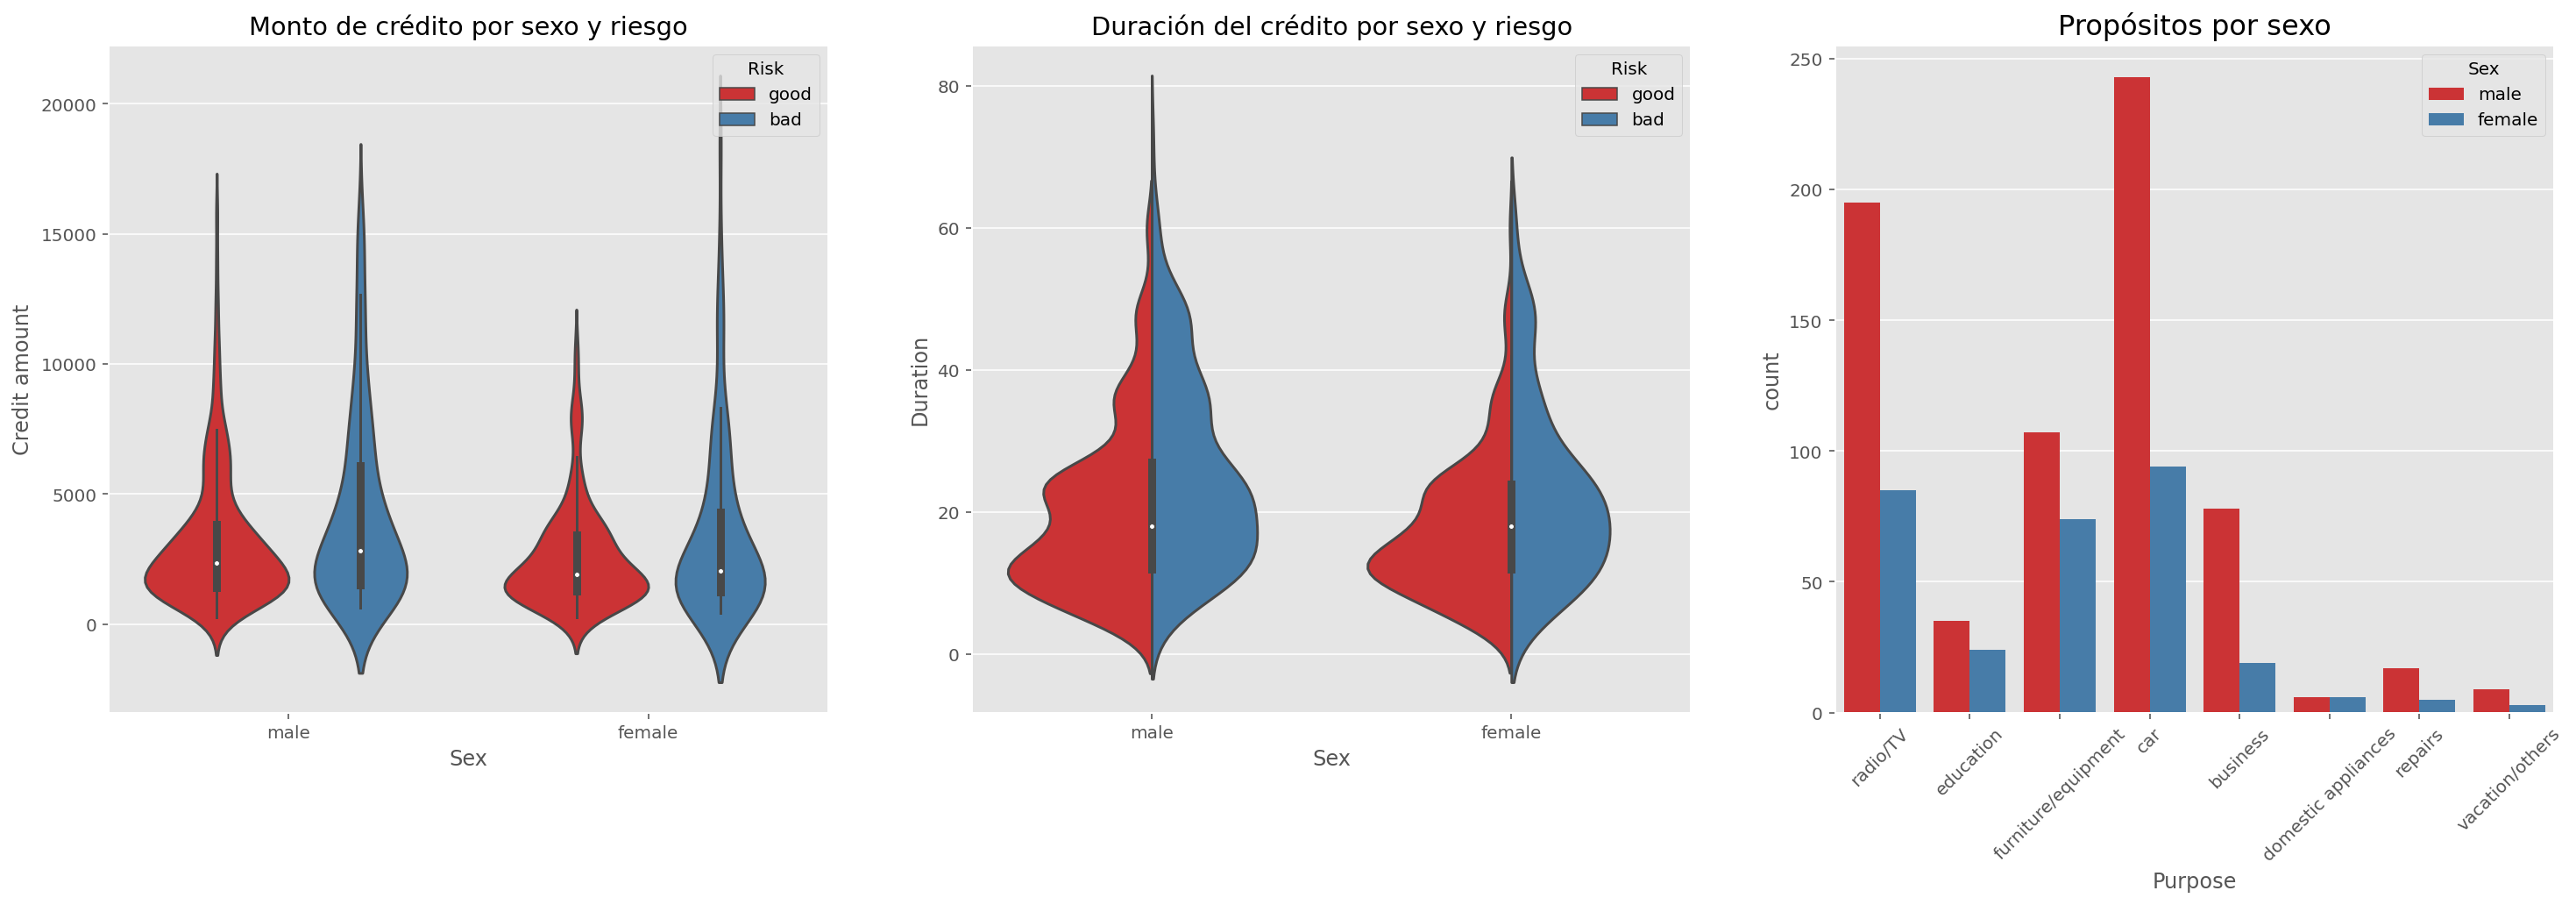

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(25,7))

sns.violinplot(x="Sex", y='Credit amount',data=df,hue = "Risk", dodge=True, ax = ax[0],palette="Set1")
ax[0].set_title("Monto de crédito por sexo y riesgo")


sns.violinplot(x="Sex", y='Duration',data=df,hue = "Risk", ax = ax[1],palette="Set1", split=True)
ax[1].set_title("Duración del crédito por sexo y riesgo")


sns.countplot(x='Purpose',data=df,palette="Set1",linewidth=1,hue = "Sex",ax = ax[2])
ax[2].set_xticklabels(labels=df['Purpose'].unique(),rotation=45)
ax[2].set_title("Propósitos por sexo", fontsize=16)


Text(0.5, 1.0, 'Sexos diferenciados por riesgo')

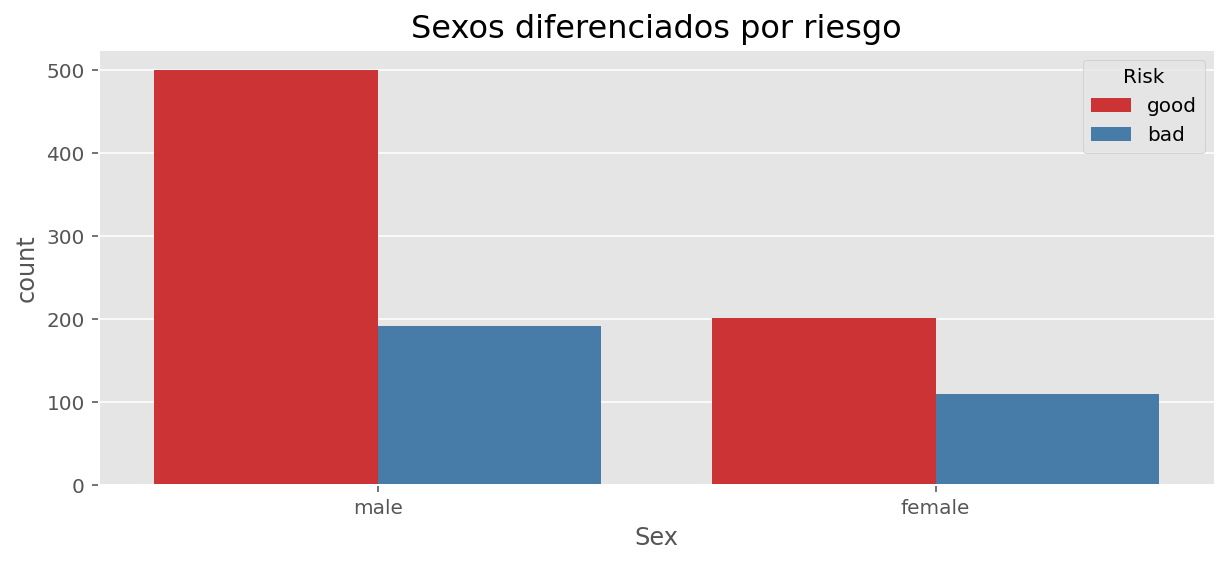

In [35]:
fig, ax = plt.subplots(figsize=(10,4))

sns.countplot(x='Sex',data=df,palette="Set1",linewidth=1,hue = "Risk")
ax.set_title("Sexos diferenciados por riesgo", fontsize=16)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Algunas relaciones con "CREDIT AMOUNT"

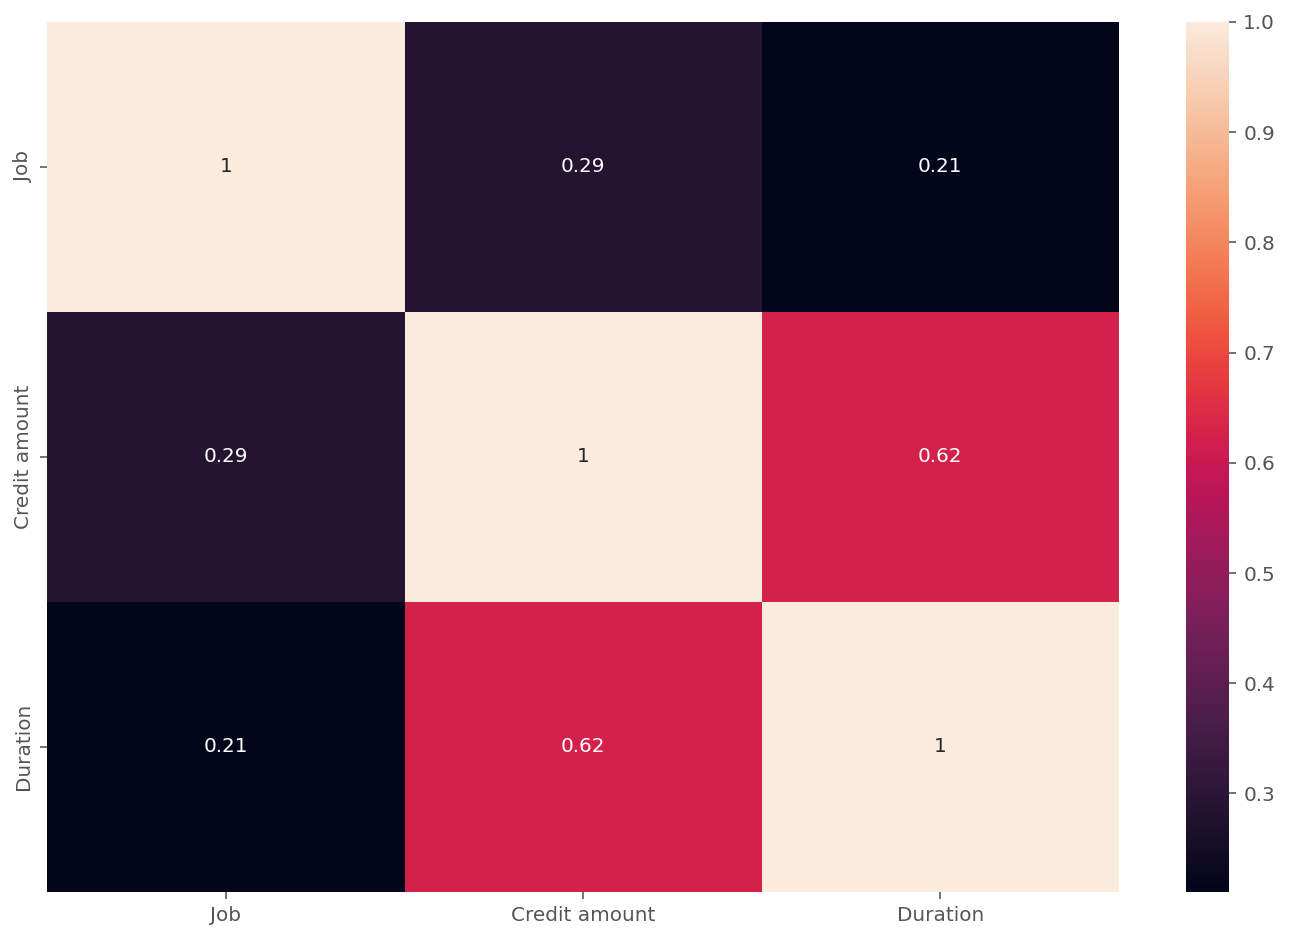

In [36]:
#Vemos las  correlaciones lineales de las variables
plt.figure(figsize=(12, 8))

vg_corr = df.corr()
sns.heatmap(vg_corr, 
            xticklabels = vg_corr.columns.values,
            yticklabels = vg_corr.columns.values,
            annot = True);

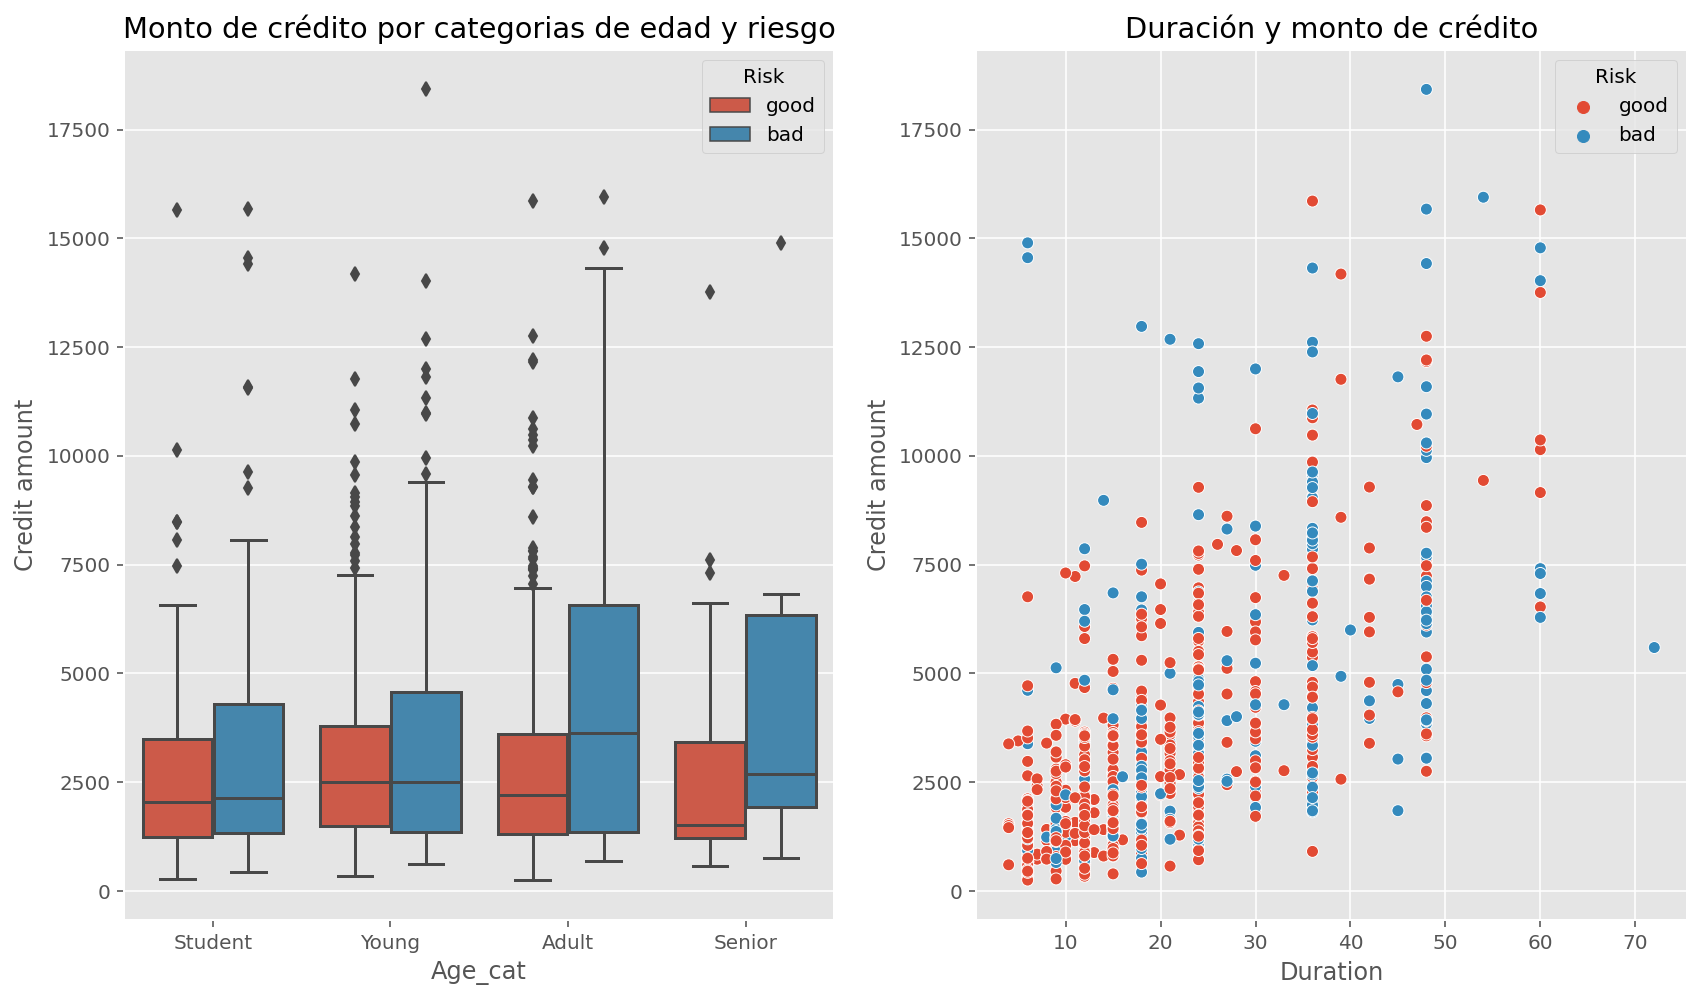

In [37]:
fig, ax = plt.subplots(1,2, figsize = (14,8))

sns.boxplot(y = "Credit amount", x = "Age_cat", data = df, ax = ax[0],hue='Risk')
ax[0].set_title("Monto de crédito por categorias de edad y riesgo")

sns.scatterplot(y = "Credit amount", x = "Duration", data = df, ax = ax[1],hue='Risk')
ax[1].set_title("Duración y monto de crédito")

plt.show()

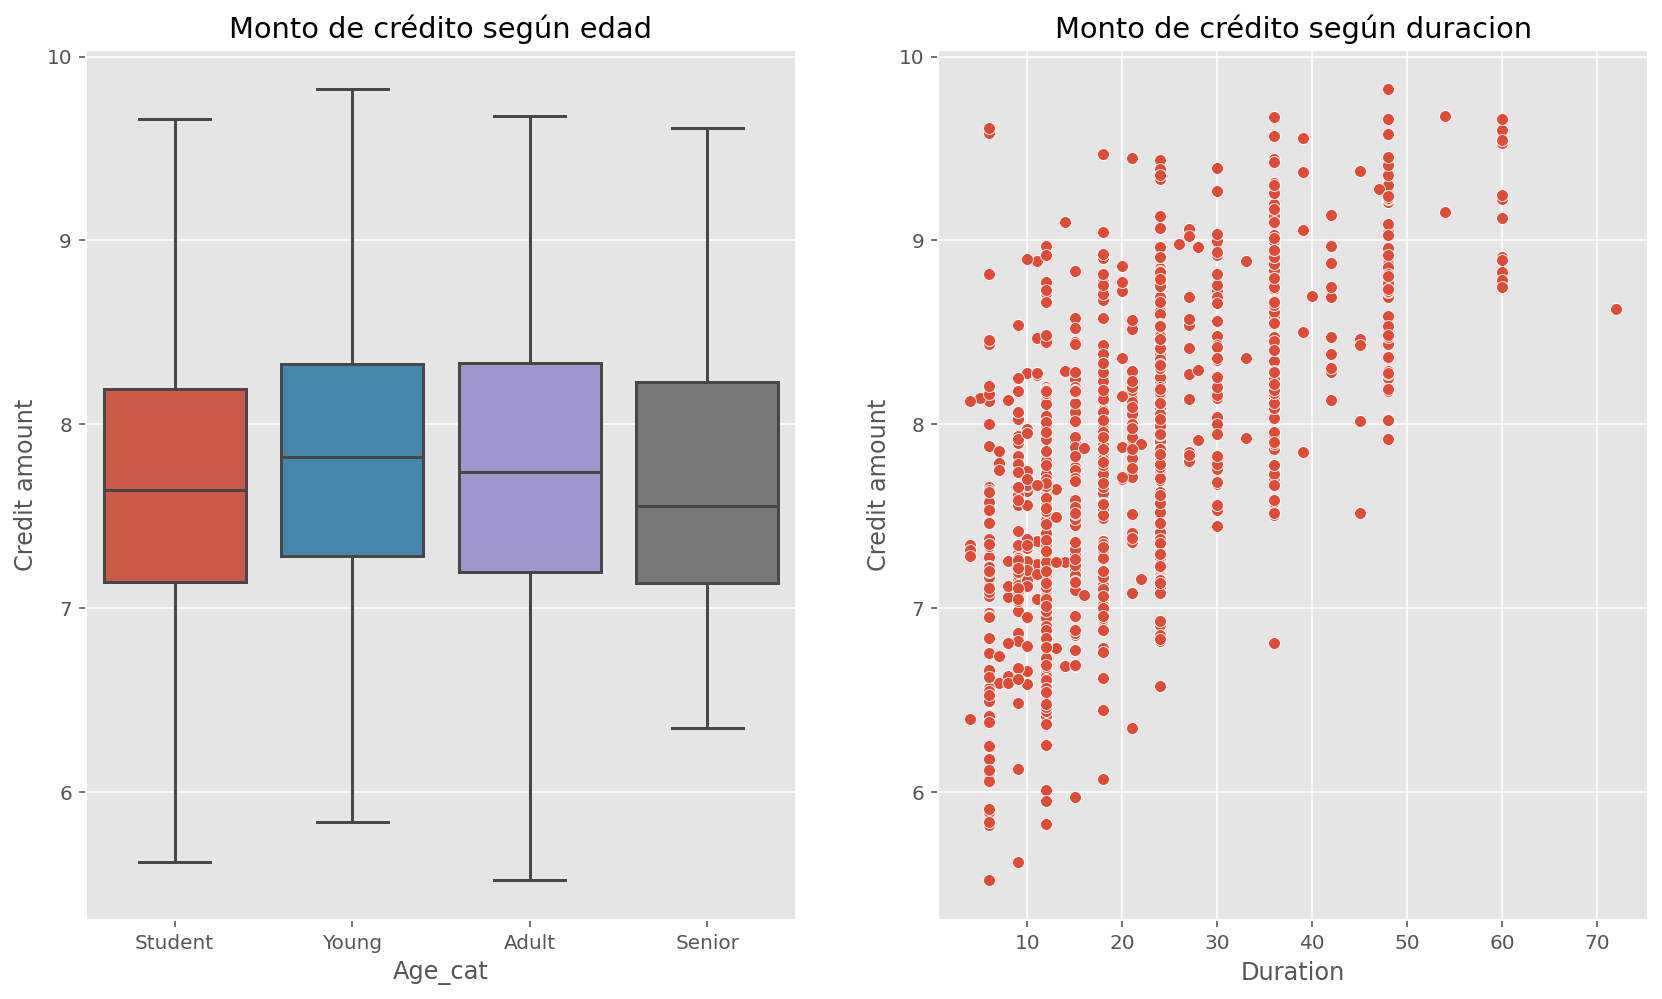

In [38]:
# Aplicamos el logaritmo a los ejes para poder ver de forma mas clara las relaciones (misma escala)
fig, ax = plt.subplots(1,2, figsize = (14,8))

sns.boxplot(y = np.log(df["Credit amount"]), x = "Age_cat", data = df, ax = ax[0])
sns.scatterplot(y = np.log(df["Credit amount"]), x = "Duration", data = df, ax = ax[1])
ax[0].set_title("Monto de crédito según edad")
ax[1].set_title("Monto de crédito según duracion")


plt.show()

##### Resumen de los datos:

- Para la gráfica de correlaciones vemos una correlación lineal moderada (0,62) entre el monto del crédito y la duración que tiene el mismo y para el resto no se ven correlaciones.
- Podemos ver una gran concentración de datos en valores de créditos menores a los 4000 euros para todas las personas con  bajo riesgo.
- Se puede ver cierto comportamiento lineal creciente entre las variables, notar que como "duration" no es continua, por eso se presentan esos gaps en blanco.
- La duración en general no supera los 50 meses.

----------------------------------------------------------------------------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Housing

#### Conclusiones

Credit amount y Housing (Risk)
- Vemos que con el tipo de casa no hay diferencias marcadas en la distribución, para los que tienen casa propia notamos una mayor concentración entre los 1000 y 2000 euros, aunque recordar que "own" concentra el 72% de los datos, despues notamos que son datos bastante dispersos.
- vemos mayor concentración de riesgos crediticios malos para personas con casa gratuita pero no propia entre los 1500  euros aprox, en relación a los riesgos malos. 
- Por otro lado vemos apenas mayor concentración de riesgos buenos en clientes con casa propia para bajos montos(1500 aprox) en comparación con los riesgos altos que estan mas dispersos en esta variable.
(Aca reiteramos que la mayoria de los aplicantes se concentran en montos de creditos menores a los 5000 euros)

Frecuencia de Housing
- La mayoria de los aplicantes tienen casa propia ("own") y con el tercer gráfico notamos que los que tienen casa propia si generan una diferencia en el resultado crediticio. Es decir, mas de la mitad de los que poseen una casa (72% aprox), son calificados como no riesgosos. Este tipo de diferenciación en los riesgos no es tan notoria en los demas tipos de casa. 
- Ademas notamos que los que tienen casa propia y los que rentan, son mas propicios a pedir montos bajos de crédito, que los que tienen casa gratuita, cuyos montos de créditos son mucho mas dispersos tanto con riesgos buenos como malos.

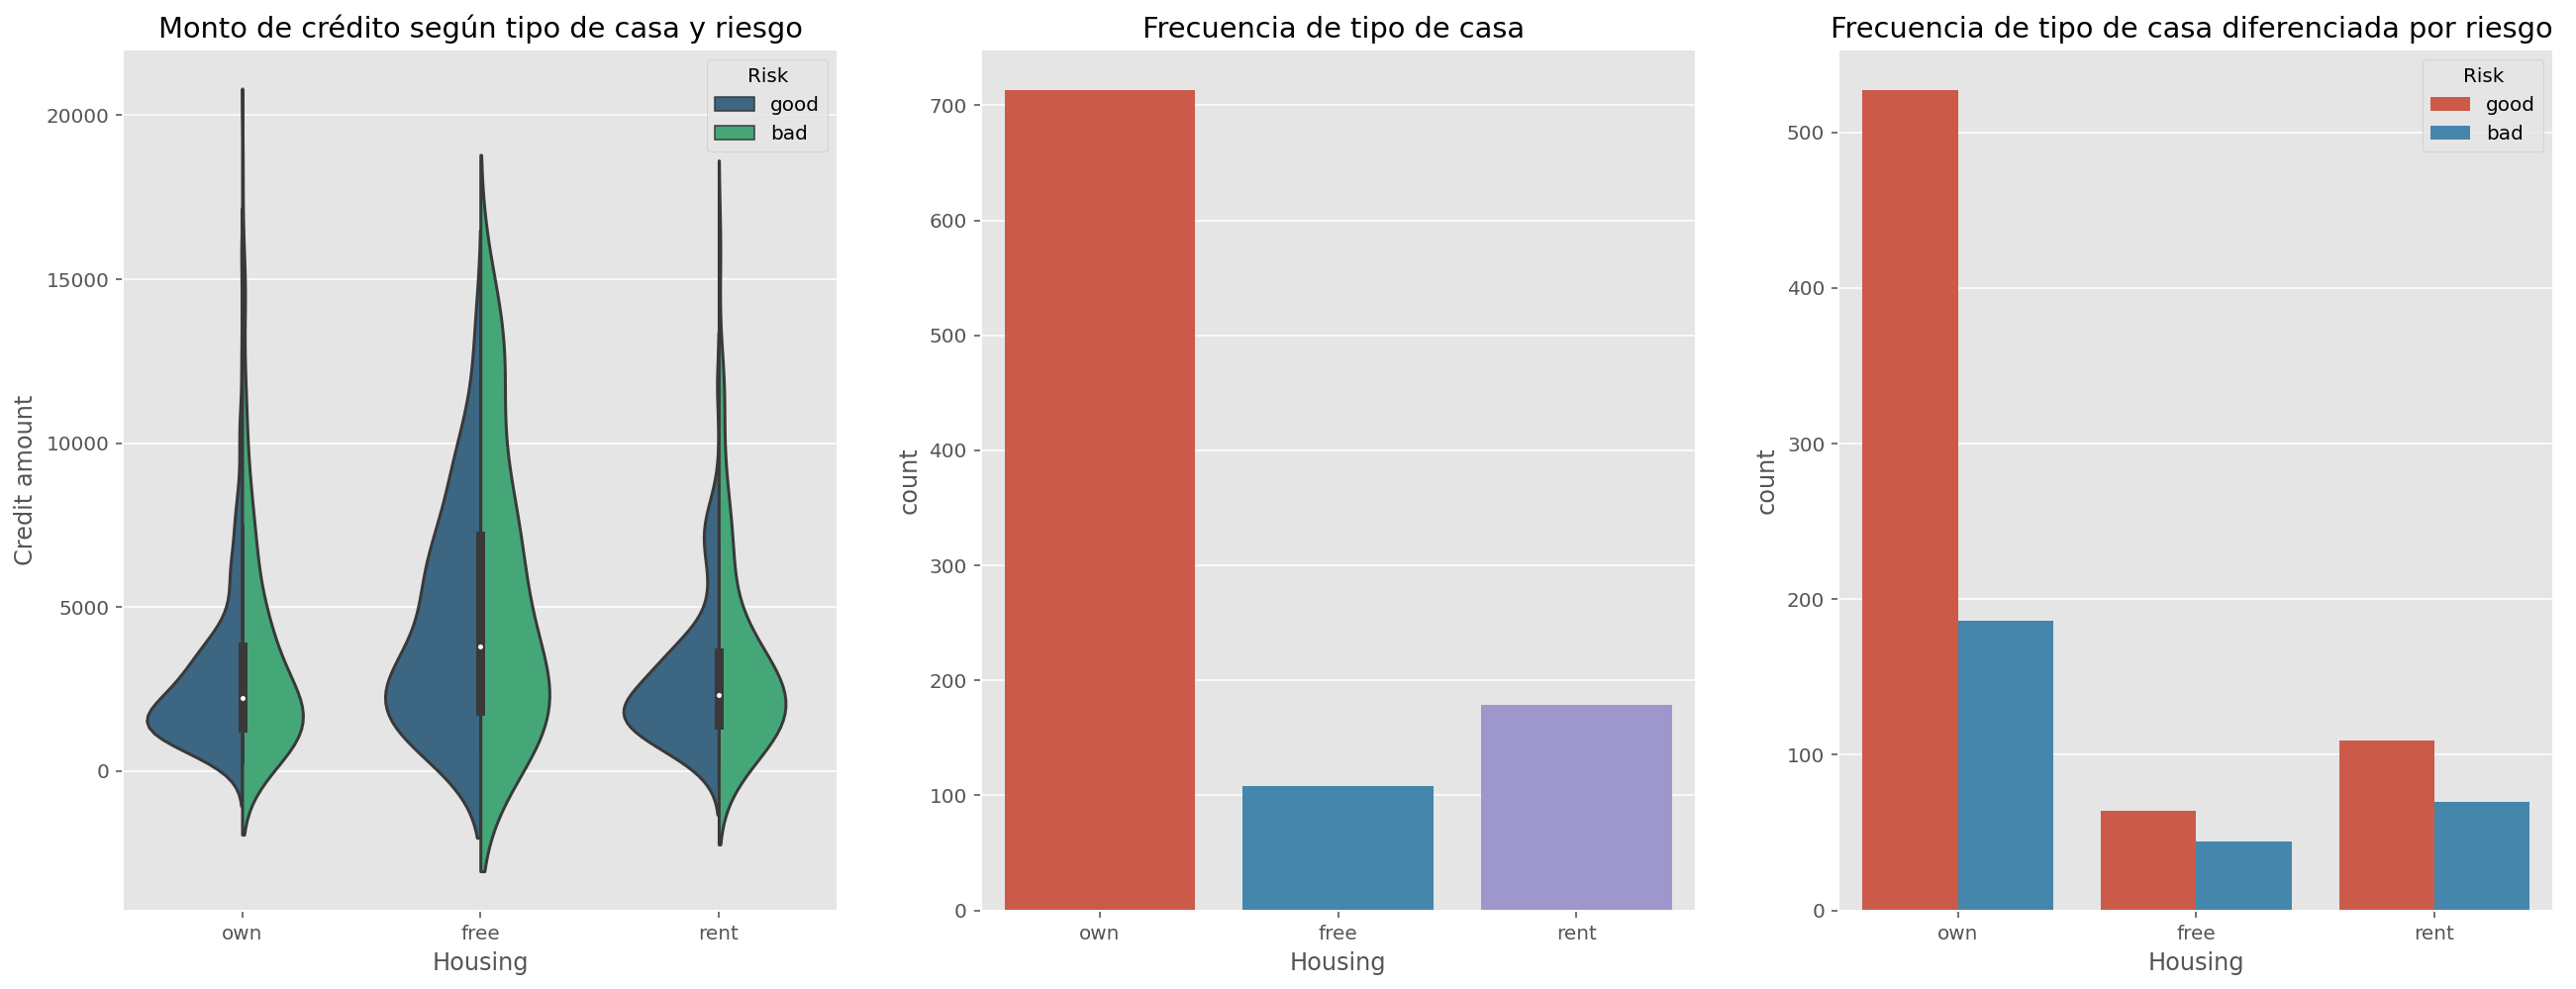

In [11]:
fig, ax = plt.subplots(1,3,figsize=(22,8))

sns.violinplot(x="Housing", y="Credit amount", hue = "Risk", data=df,dodge=True, palette='viridis', ax = ax[0], split=True)
ax[0].set_title("Monto de crédito según tipo de casa y riesgo")

sns.countplot(x="Housing",data=df, dodge=True, ax = ax[1])
ax[1].set_title("Frecuencia de tipo de casa ")

sns.countplot(x="Housing", hue= "Risk",data=df, dodge=True, ax = ax[2])
ax[2].set_title("Frecuencia de tipo de casa diferenciada por riesgo ")

plt.show()

In [12]:
# TEST DE CHI CUADRADO PARA VER SI EL TIPO DE CASA ES INDEPENDIENTE DE LA SAVINGS ACCOUNT --> NO QUEREMOS QUE DOS VARIABLES EXPLIQUEN EL MISMO EFECTO EN LA VARIABLE TARGET
from scipy.stats import chisquare
print(df.groupby(['Housing','Saving accounts']).count())
pd.crosstab(df.Housing,df['Saving accounts'],margins=True)

                         Sex  Job  Checking account  Credit amount  Duration  \
Housing Saving accounts                                                        
free    No                23   23                23             23        23   
        little            67   67                67             67        67   
        moderate          10   10                10             10        10   
        quite rich         6    6                 6              6         6   
        rich               2    2                 2              2         2   
own     No               130  130               130            130       130   
        little           430  430               430            430       430   
        moderate          71   71                71             71        71   
        quite rich        45   45                45             45        45   
        rich              37   37                37             37        37   
rent    No                30   30       

Saving accounts,No,little,moderate,quite rich,rich,All
Housing,,,,,,
free,23,67,10,6,2,108
own,130,430,71,45,37,713
rent,30,106,22,12,9,179
All,183,603,103,63,48,1000


In [13]:
pd.crosstab(df.Housing,df['Saving accounts'],margins=True ,normalize='index')
# Vemos los "free" y "own" tienen poca plata en su caja de ahorro o no tienen
# Vemos que los que rentan tienen la mayoria poca plata, con menor proporcion no tienen y por ultimo tenemos algunos que si tienen moderada cantidad 


Saving accounts,No,little,moderate,quite rich,rich
Housing,,,,,
free,0.212963,0.620370,0.092593,0.055556,0.018519
own,0.182328,0.603086,0.099579,0.063114,0.051893
rent,0.167598,0.592179,0.122905,0.067039,0.050279
All,0.183000,0.603000,0.103000,0.063000,0.048000


In [14]:
pd.crosstab(df.Housing,df['Saving accounts'],margins=True ,normalize='columns')

Saving accounts,No,little,moderate,quite rich,rich,All
Housing,,,,,,
free,0.125683,0.111111,0.097087,0.095238,0.041667,0.108
own,0.710383,0.713101,0.689320,0.714286,0.770833,0.713
rent,0.163934,0.175788,0.213592,0.190476,0.187500,0.179


In [15]:
# Construyo la tabla de contingencia entre las dos variables y lo paso a formato numpy
table = pd.crosstab(df.Housing,df['Saving accounts']).to_numpy()
table

array([[ 23,  67,  10,   6,   2],
       [130, 430,  71,  45,  37],
       [ 30, 106,  22,  12,   9]], dtype=int64)

In [16]:
prob = 0.95
alpha = 1.0 - prob

In [17]:
stat, p, dof, expected = chi2_contingency(table)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpretando el estadístico de prueba
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Se rechaza la hipótesis nula, por lo tanto las variables probablemente son dependientes')
else:
    print('No se rechaza la hipóteiss nula de que las variables son independientes')

stat=4.077, p=0.850
No se rechaza la hipóteiss nula de que las variables son independientes


##### Conclusión

No podemos asegurar que las variables sean independientes, lo cual indica que probablemente sean dependientes.

### CRAMER

Interpretación de resultados:

- Con un p-valor inferior a 0,05, rechazamos la hipótesis nula (H0: sin relación entre las 2 variables). 
- Mirando la V de Cramer, la fuerza de la dependencia es baja.

In [18]:
# UTILIZO EL COEFICIENTE DE CRAMER PARA VER LA FUERZA DE ESTA SUPUESTA DEPENDENCIA 
# chi-square test
chiRes2 = stats.chi2_contingency(table)
# chi-square test
print(f'chi-2 statistic: {chiRes2[0]}')
print(f'p-value of chi-2: {chiRes2[1]}')
# chi-square test statistic (alternative method to derive chi-sq stat)
chisq_stat = stats.chi2_contingency(table, correction=False)[0]
# sample size
n = np.sum(np.sum(table))
# minimum of rows & columns
minshape = min(table.shape)-1
# Cramer's v
V_ = np.sqrt( (chisq_stat/n)/minshape)
print(f"Cramer' V: {V_}")

chi-2 statistic: 4.077235949004876
p-value of chi-2: 0.8500885538998767
Cramer' V: 0.04515105729108055


**********************************************************************************************************************************************************************
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Saving Accounts

##### Conclusiones

- La mayoria de los deudores tienen poco monto o en segundo lugar no tienen cajas de ahorro ("little" o "no").
- Los que tienen cajas de ahorro de tipo "no", "little" y "moderate" son mas probables de ser clasificados como riesgosos si superan el monto de los 5000 euros. 
- Con duraciones mayores a los 30 meses son mas problables de ser clasificados como créditos riesgosos.
- Los que tienen cuentas de ahorro con mas monto, son mas propensos a ser calificados de bajo riesgo ("rich" y "quite rich").

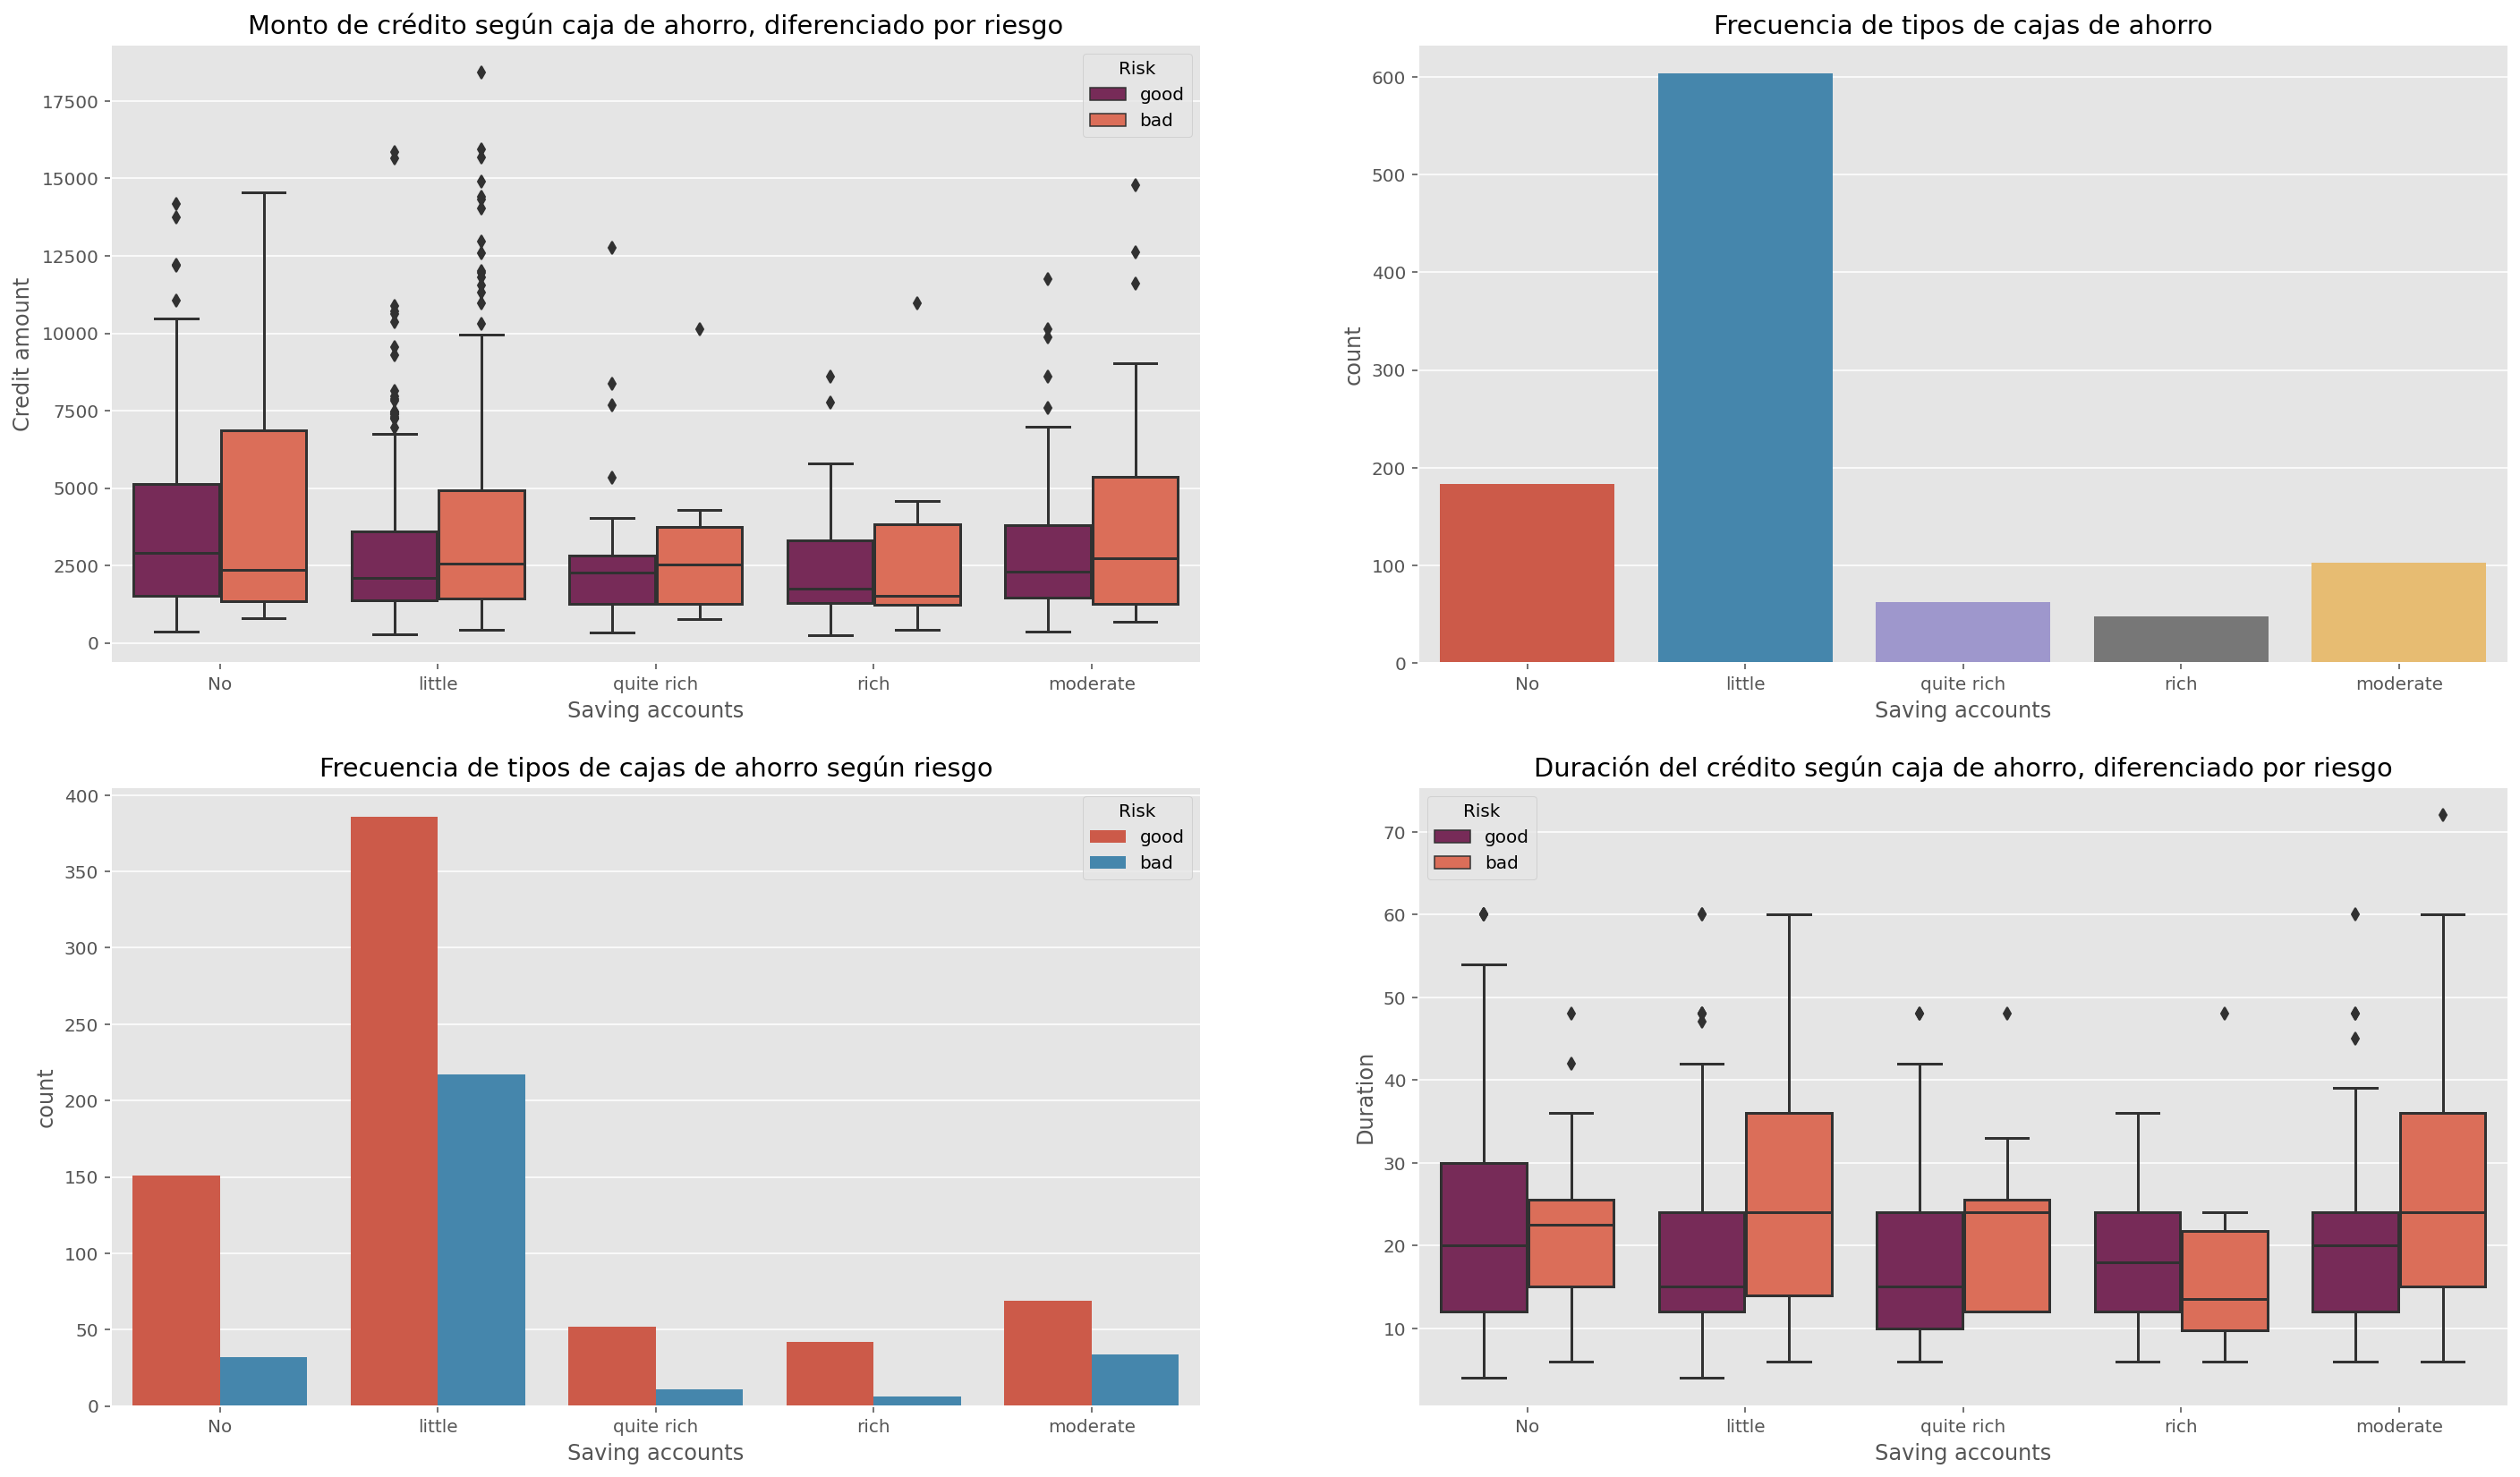

In [47]:
fig, ax = plt.subplots(2,2,figsize=(24,14))


sns.boxplot(x="Saving accounts", y='Credit amount',hue = 'Risk',data=df ,dodge=True, palette='rocket', ax = ax[0,0])
ax[0,0].set_title("Monto de crédito según caja de ahorro, diferenciado por riesgo")

sns.countplot(x="Saving accounts",data=df, dodge=True, ax = ax[0,1])
ax[0,1].set_title("Frecuencia de tipos de cajas de ahorro")

sns.countplot(x="Saving accounts", hue= "Risk", data=df, dodge=True, ax = ax[1,0])
ax[1,0].set_title("Frecuencia de tipos de cajas de ahorro según riesgo")

sns.boxplot(x="Saving accounts", y='Duration',hue = 'Risk',data=df ,dodge=True, palette='rocket', ax = ax[1,1])
ax[1,1].set_title("Duración del crédito según caja de ahorro, diferenciado por riesgo")

plt.show()

**********************************************************************************************************************************************************************
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Checking account

#### Conclusiones

- La mayoria de los aplicantes no tienen cuenta corriente.
- Los que no tienen cuenta corriente son ampliamente categorizados como de bajo riesgo.
- Mas de la mitad de los que tienen cuentas corrientes de montos acaudalados (rich) son calificados como de bajo riesgo.
- Mas del 50% de los que no tienen cuenta corriente son  jóvenes (Young: 25 - 35 años) y  adultos (Adult:35 - 60 años).
- Los aplicantes con cuentas corrientes de poco monto o que no tienen cuenta ("no", "little" and "moderate") que a su vez piden montos mas altos de crédito tienen mas probabilidad de ser clasificados como riesgosos.

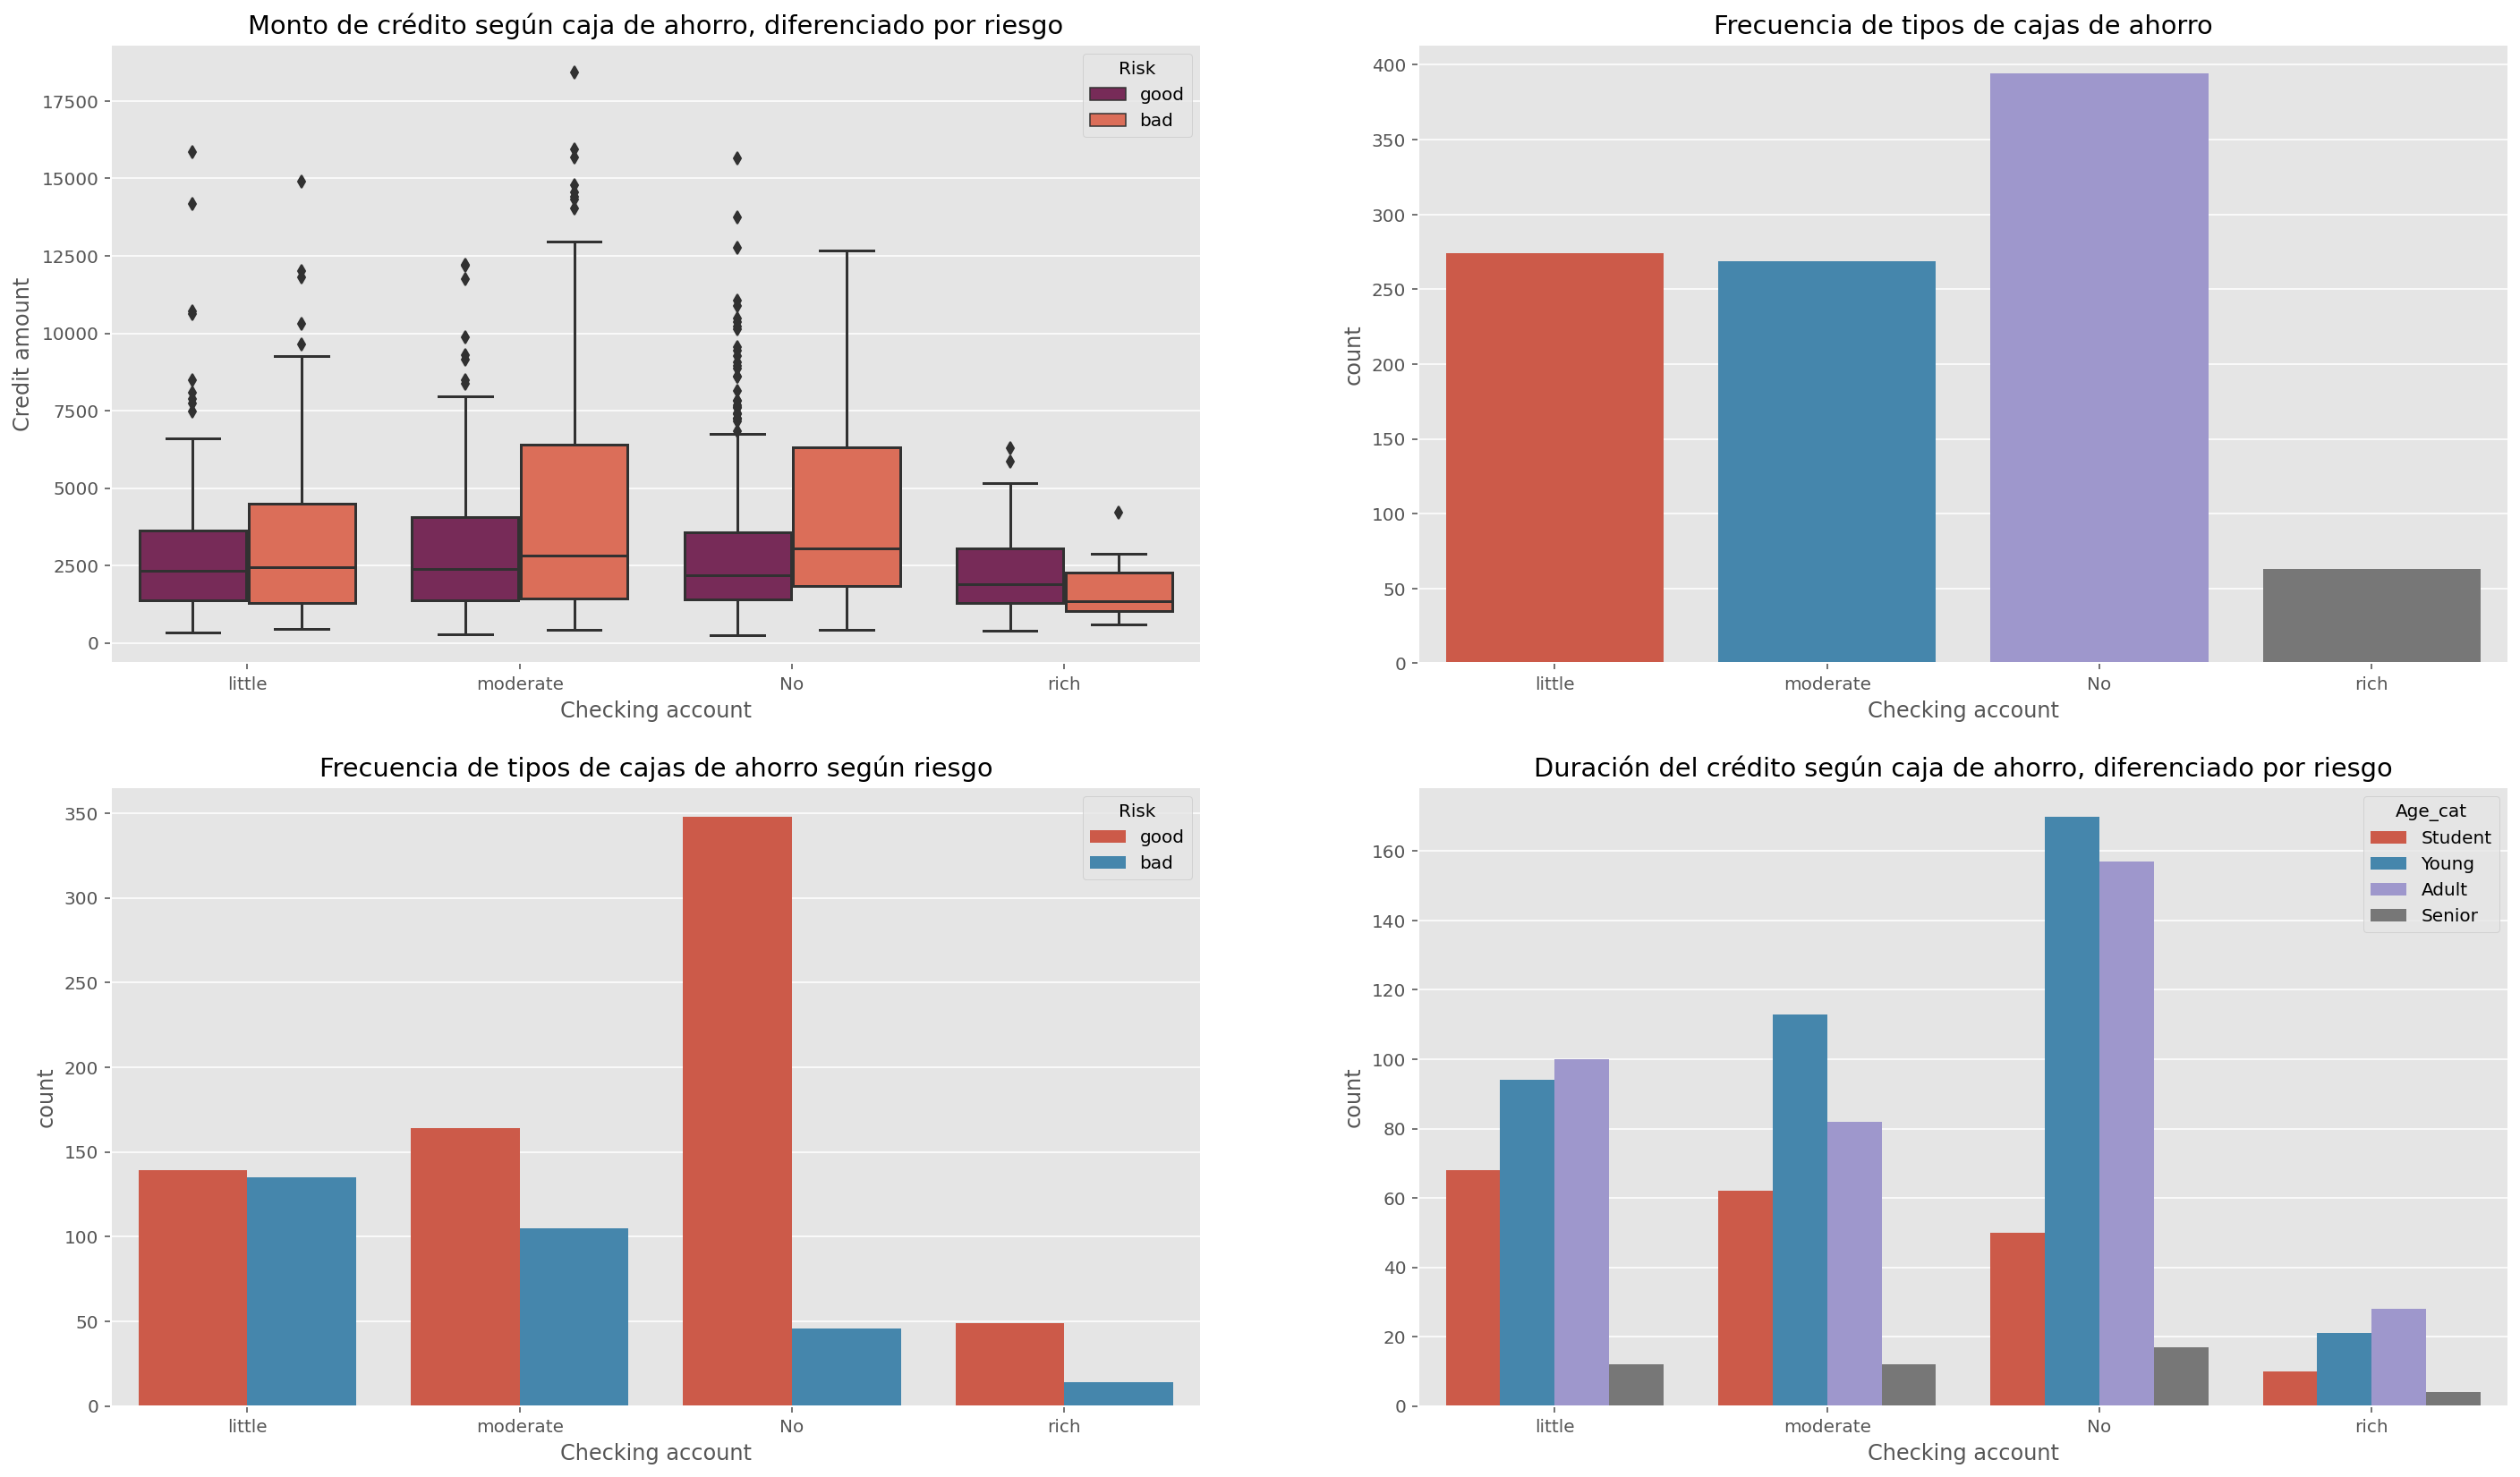

In [48]:
fig, ax = plt.subplots(2,2,figsize=(24,14))


sns.boxplot(x="Checking account", y='Credit amount',hue = 'Risk',data=df ,dodge=True, palette='rocket', ax = ax[0,0])
ax[0,0].set_title("Monto de crédito según caja de ahorro, diferenciado por riesgo")

sns.countplot(x="Checking account",data=df, dodge=True, ax = ax[0,1])
ax[0,1].set_title("Frecuencia de tipos de cajas de ahorro")

sns.countplot(x="Checking account", hue= "Risk", data=df, dodge=True, ax = ax[1,0])
ax[1,0].set_title("Frecuencia de tipos de cajas de ahorro según riesgo")

sns.countplot(x="Checking account",data=df, hue = "Age_cat", dodge=True, ax = ax[1,1])
ax[1,1].set_title("Duración del crédito según caja de ahorro, diferenciado por riesgo")

plt.show()

In [49]:
# GENERO EL TEST PARA TESTEAR LA DEPENDENCIA ENTRE LAS VARIABLES CHECKING ACCOUNT Y SAVING ACCOUNTS
table1 = pd.crosstab(df['Checking account'],df['Saving accounts']).to_numpy()
table1

array([[ 99, 191,  39,  40,  25],
       [ 29, 219,  12,   8,   6],
       [ 45, 152,  47,  11,  14],
       [ 10,  41,   5,   4,   3]], dtype=int64)

In [50]:
stat, p, dof, expected = chi2_contingency(table1)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpretando el estadístico de prueba
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Se rechaza la hipótesis nula, por lo tanto las variables probablemente son dependientes')
else:
    print('no se rechaza la hipóteiss nula de que las variables son independientes')

stat=92.473, p=0.000
Se rechaza la hipótesis nula, por lo tanto las variables probablemente son dependientes


In [51]:
# UTILIZO EL COEFICIENTE DE CRAMER PARA VER LA FUERZA DE ESTA SUPUESTA DEPENDENCIA 
# chi-square test
chiRes2 = stats.chi2_contingency(table1)
# chi-square test
print(f'chi-2 statistic: {chiRes2[0]}')
print(f'p-value of chi-2: {chiRes2[1]}')
# chi-square test statistic (alternative method to derive chi-sq stat)
chisq_stat = stats.chi2_contingency(table1, correction=False)[0]
# sample size
n = np.sum(np.sum(table1))
# minimum of rows & columns
minshape = min(table1.shape)-1
# Cramer's v
V_ = np.sqrt( (chisq_stat/n)/minshape)
print(f"Cramer' V: {V_}")


chi-2 statistic: 92.47328092678495
p-value of chi-2: 1.6365301038541542e-14
Cramer' V: 0.17556886676058195


#### Conclusión

Dependencias de menos del 0,20 es baja dependencia. Por lo tanto no podemos argumentar que ambas variables tengan un mismo efecto en la variable target. No veo justificación para la eliminación de alguna de estas variables.

**********************************************************************************************************************************************************************
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Purpose

#### Conclusiones

- La mayoria de los deudores pidieron créditos para la compra de un auto o radio/TV.
- De los que piden un crédito para radio/TV, mas del 90% son de bajo riesgo.
- De los que piden crédito para un auto, mas del doble son creditos de bajo riesgo. (lo mismo ocurre con los creditos para muebles/equipamiento)
- Los jovenes (Young: 25 - 35 años) y  adultos (Adult:35 - 60 años) son los que ponderan mas a la hora de pedir credito para auto y radio/tv.
- Los montos mas bajos de creditos se concentran para educacion y articulos domesticos. Los creditos por vacaciones son los que menos dispersion tienen, centrandose en valores entre los 1000 y 2000 euros 
- Para el proposito mas frecuente en otorgammientos de creditos, tenemos una leve acumulacion en los 1000 y 1500 euros, aunque su distribucion es bastante dispersa en valores de credito 
- Los creditos para vacaciones que superen los 7500 euros son muy probables de ser de alto riesgo.
- Vemos una gran distincion en los que son destinados a negocios, ya que aca vemos que los que tienen mas de 30 meses son de alto riesgo, otra gran diferencia se ve en los articulos domesticos , preferentemente considerados de bajo riesgo los que son de un plazo igual o menor a los 12 meses 

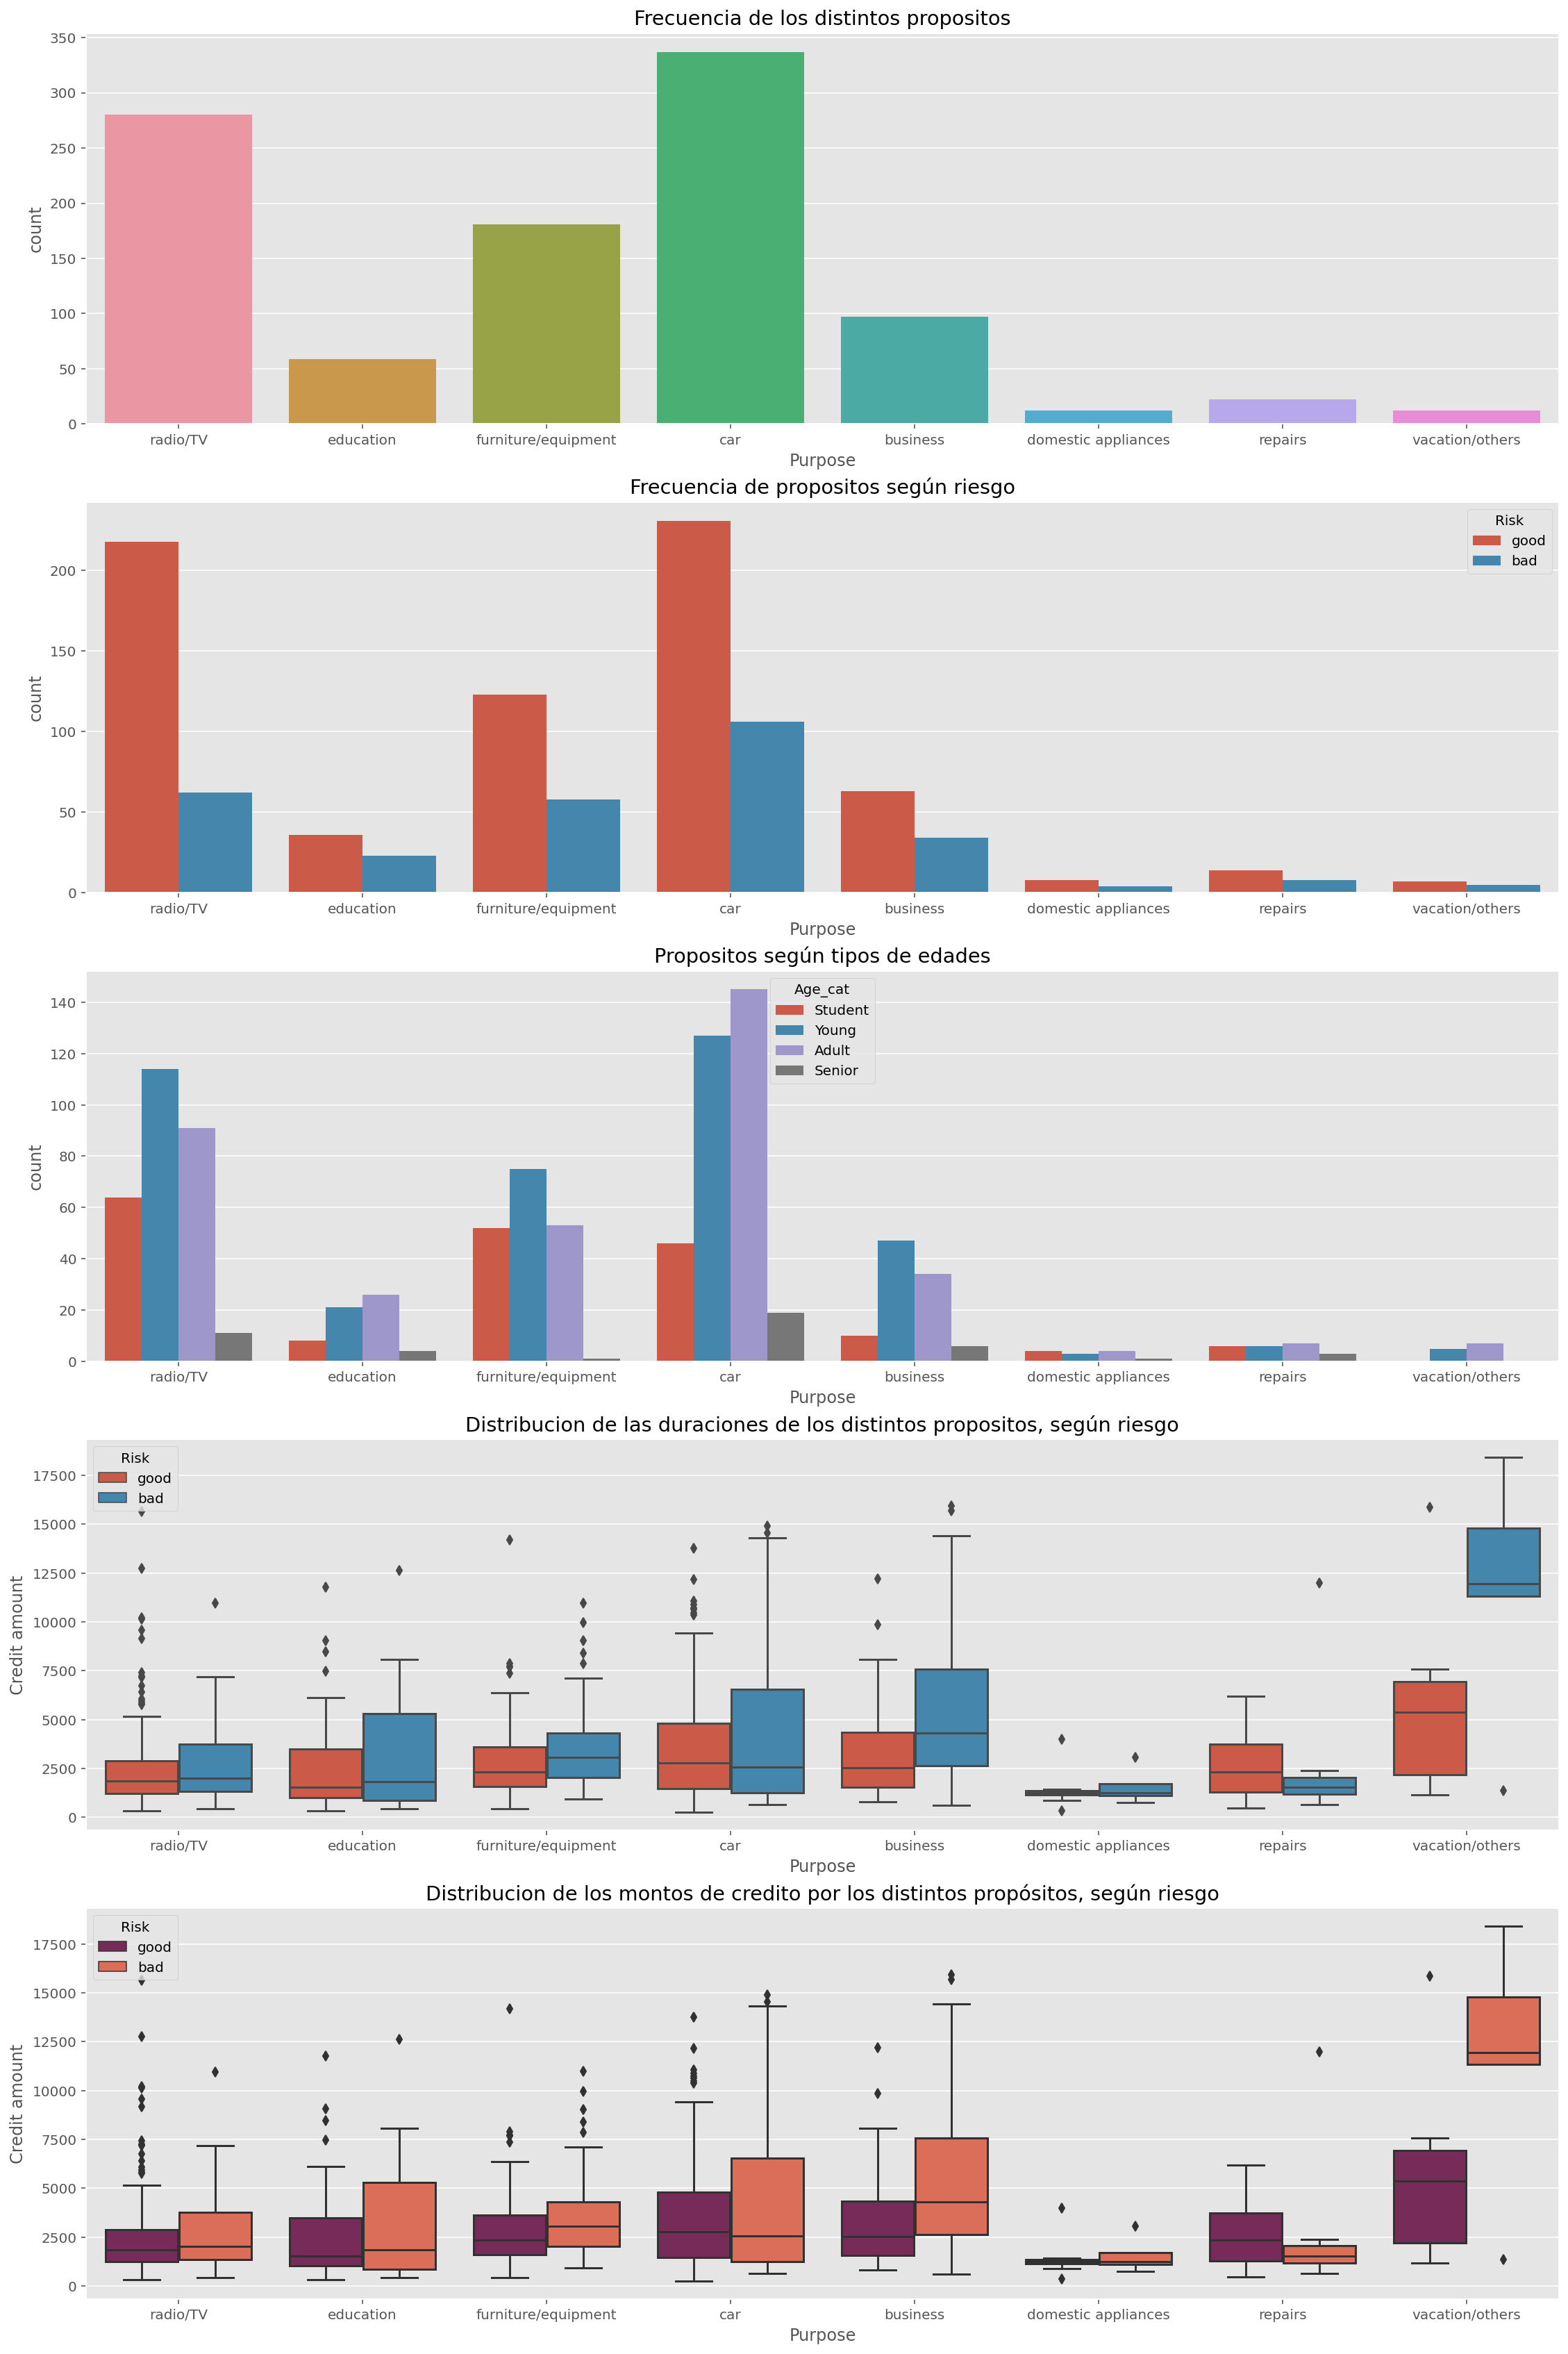

In [52]:
fig, ax = plt.subplots(nrows = 5,ncols =1,figsize=(19,30))

sns.countplot(x="Purpose",data=df, dodge=True, ax = ax[0])
ax[0].set_title("Frecuencia de los distintos propositos")

sns.countplot(x="Purpose", hue= "Risk", data=df, dodge=True, ax = ax[1])
ax[1].set_title("Frecuencia de propositos según riesgo")

sns.countplot(x="Purpose",data=df, hue = "Age_cat", dodge=True, ax = ax[2])
ax[2].set_title("Propositos según tipos de edades")

sns.boxplot(x="Purpose", y='Credit amount',hue = 'Risk',data=df ,dodge=True, ax = ax[3])
ax[3].set_title("Distribucion de las duraciones de los distintos propositos, según riesgo")

sns.boxplot(x="Purpose", y='Credit amount',hue = 'Risk',data=df ,dodge=True, palette='rocket', ax = ax[4])
ax[4].set_title("Distribucion de los montos de credito por los distintos propósitos, según riesgo")

plt.show()

**********************************************************************************************************************************************************************
----------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Job

#### Conclusiones

Recordando los tipos de trabajos:  0 - no calificado y no residente, 1 - no calificado y residente, 2 - calificado, 3 - altamente calificado

- Los trabajos mas frecuentes son los de tipo calificado y mas del 60% de los mismos, son calificados como no riesgosos. 
- Mas del 60% de los trabajos de tipo 1, son calificados como no riesgosos. 
- Los solicitantes del tipo 3, son los que mas dispersion tienen en el monto de credito que suelen solicitar, cuanto mas alto el monto mas probabilidad de ser calificado como riesgoso

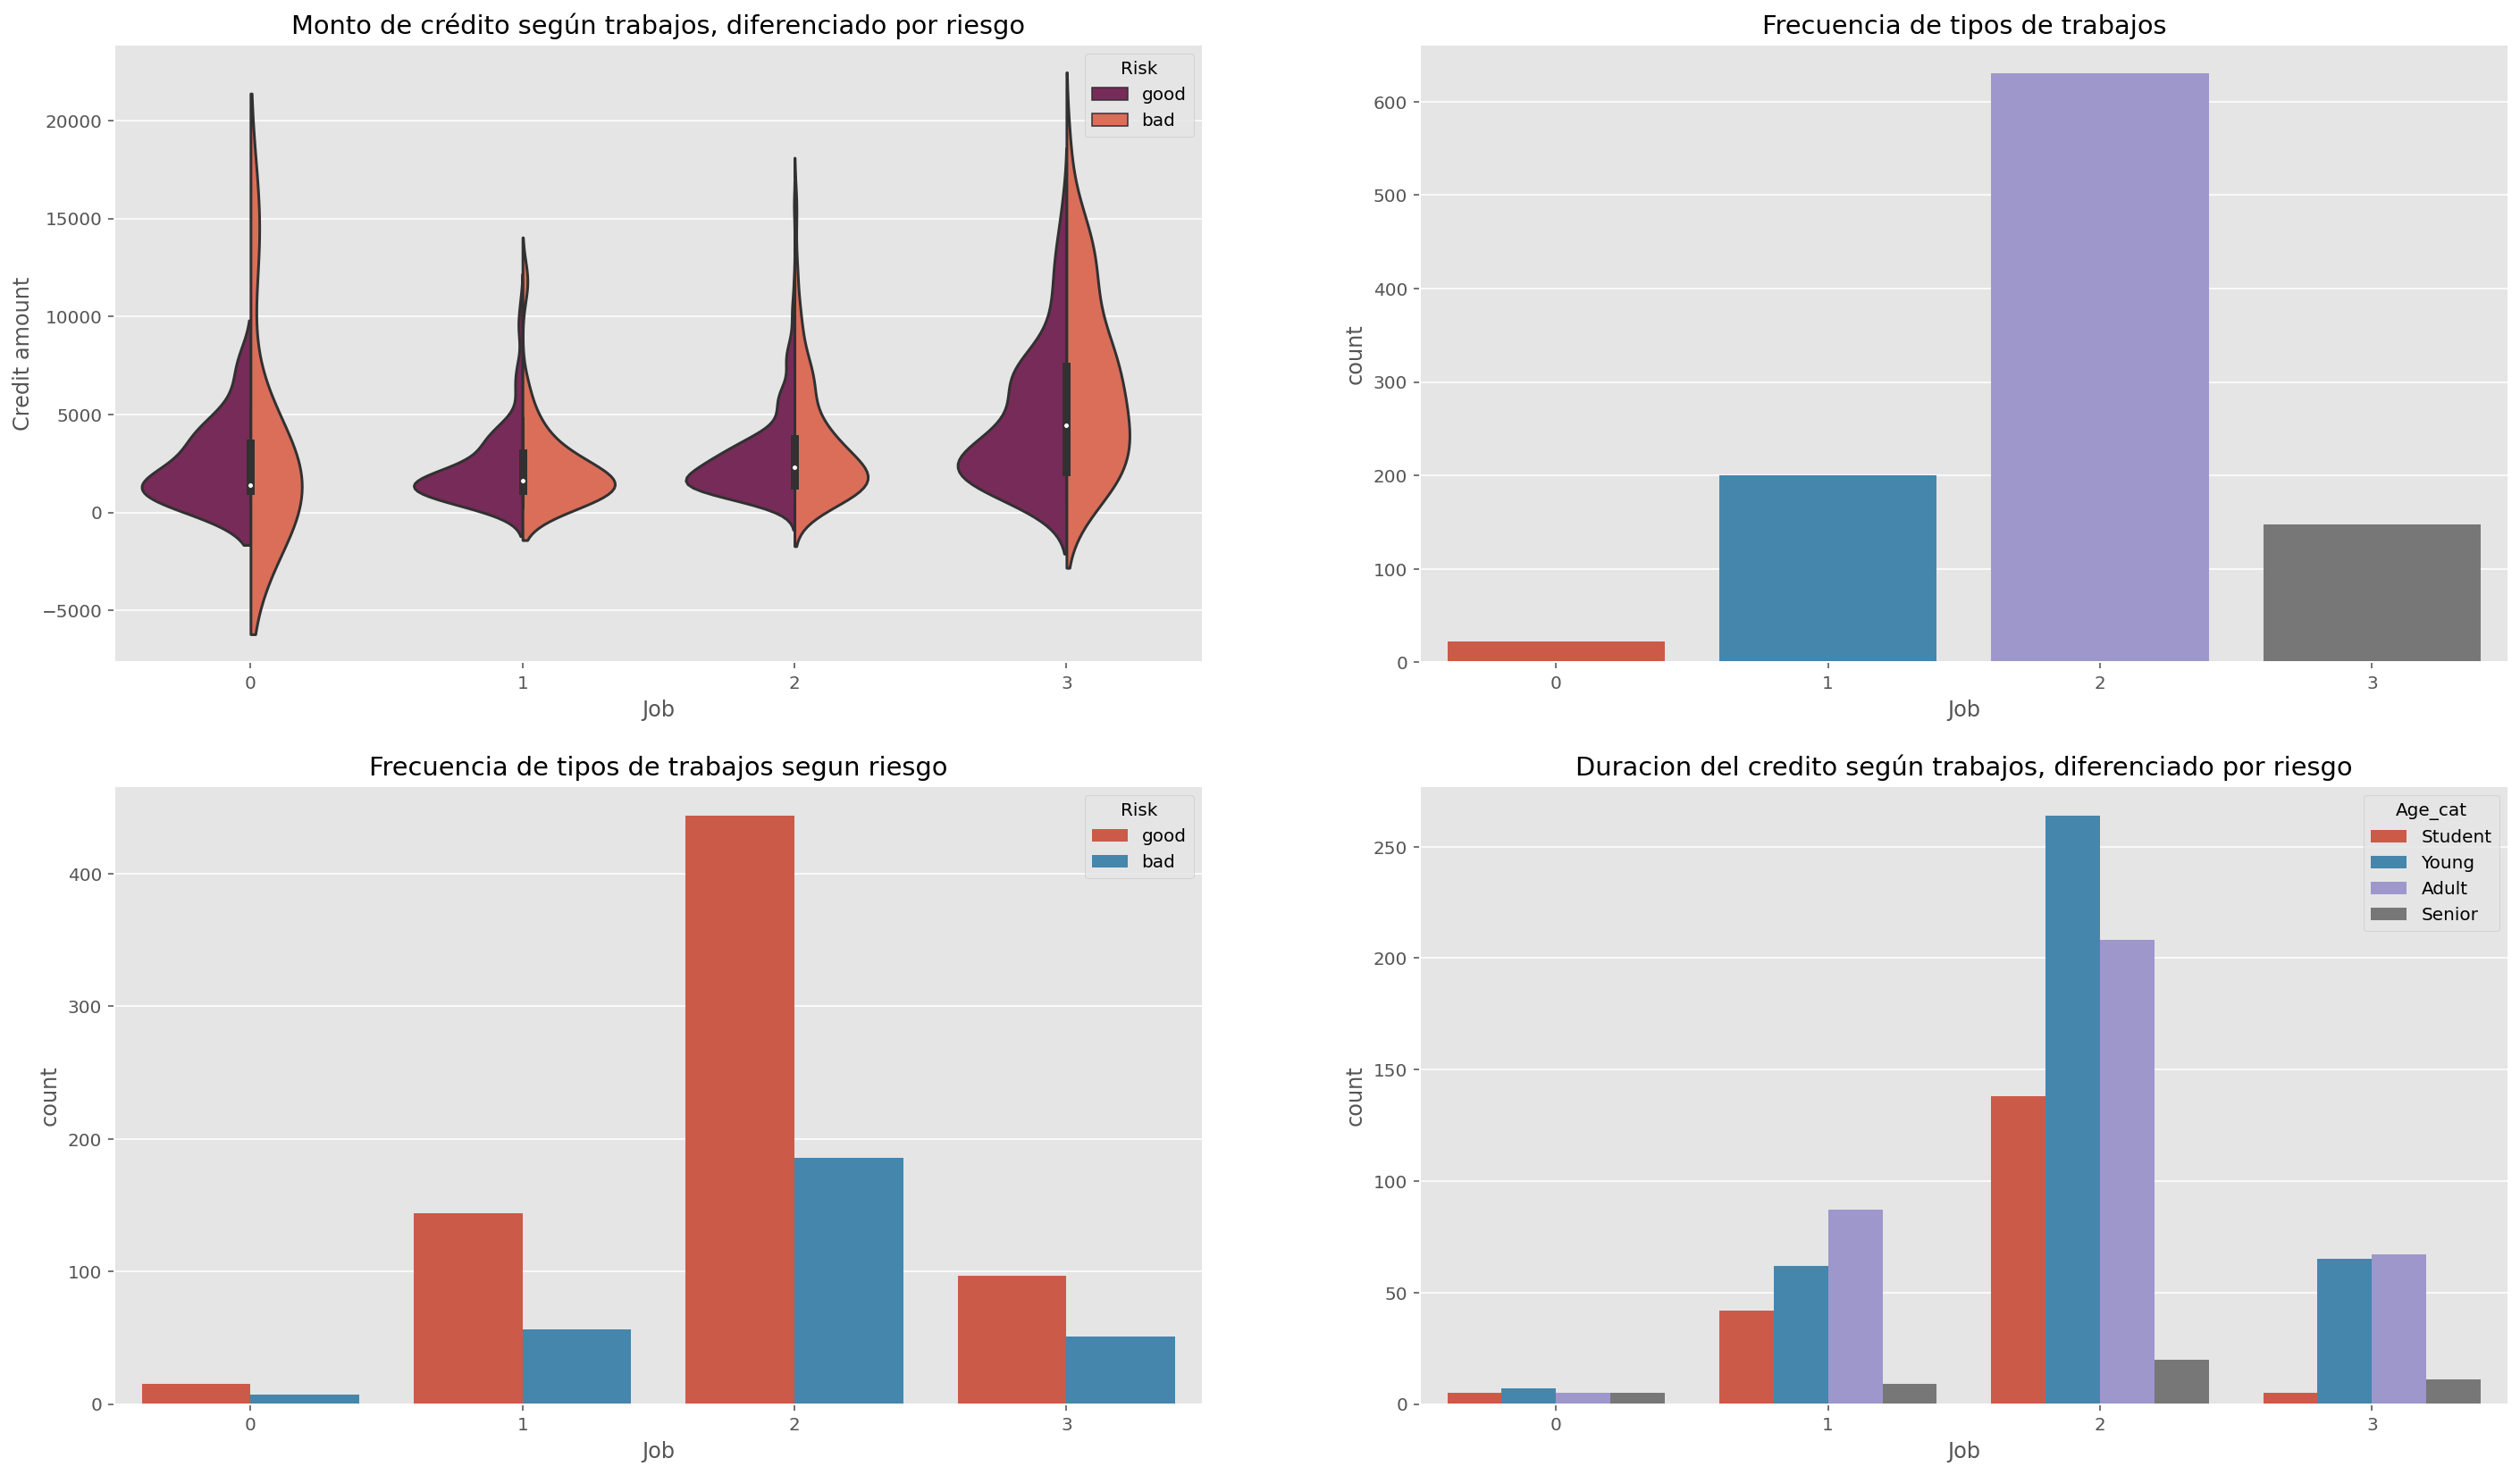

In [53]:
fig, ax = plt.subplots(2,2,figsize=(24,14))


sns.violinplot(x="Job", y='Credit amount',hue = 'Risk',data=df ,dodge=True, palette='rocket', ax = ax[0,0], split=True)
ax[0,0].set_title("Monto de crédito según trabajos, diferenciado por riesgo")

sns.countplot(x="Job",data=df, dodge=True, ax = ax[0,1])
ax[0,1].set_title("Frecuencia de tipos de trabajos")

sns.countplot(x="Job", hue= "Risk", data=df, dodge=True, ax = ax[1,0])
ax[1,0].set_title("Frecuencia de tipos de trabajos segun riesgo")

sns.countplot(x="Job",data=df, hue = "Age_cat", dodge=True, ax = ax[1,1])
ax[1,1].set_title("Duracion del credito según trabajos, diferenciado por riesgo")

plt.show()

In [54]:
# SE QUIERE COMPROBAR QUE LA VARIABLE JOB NO TENGA CORRELACION CON ALGUNA DE LAS OTRAS EXPLICATIVAS QUE YA DESARROLLAMOS 
# UTILIZAMOS EL TEST DE CHI Y CRAMER PARA ESTO 
# GENERO EL TEST PARA TESTEAR LA DEPENDENCIA ENTRE LAS VARIABLES JOB Y SAVING ACCOUNTS
table2 = pd.crosstab(df['Job'],df['Saving accounts']).to_numpy()
table2

array([[  5,  13,   0,   3,   1],
       [ 29, 128,  23,  12,   8],
       [120, 366,  66,  42,  36],
       [ 29,  96,  14,   6,   3]], dtype=int64)

In [55]:
stat, p, dof, expected = chi2_contingency(table2)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpretando el estadístico de prueba
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Se rechaza la hipótesis nula, por lo tanto las variables probablemente son dependientes')
else:
    print('no se rechaza la hipóteiss nula de que las variables son independientes')

stat=13.252, p=0.351
no se rechaza la hipóteiss nula de que las variables son independientes


In [56]:
#Interpretación de resultados:

#Con un p-valor inferior a 0,05, rechazamos la hipótesis nula (H0: sin relación entre las 2 variables). Mirando la V de Cramer, la fuerza de la dependencia es baja.

chiRes2 = stats.chi2_contingency(table2)
# chi-square test
print(f'chi-2 statistic: {chiRes2[0]}')
print(f'p-value of chi-2: {chiRes2[1]}')
# chi-square test statistic (alternative method to derive chi-sq stat)
chisq_stat = stats.chi2_contingency(table2, correction=False)[0]
# sample size
n = np.sum(np.sum(table2))
# minimum of rows & columns
minshape = min(table2.shape)-1
# Cramer's v
V_ = np.sqrt( (chisq_stat/n)/minshape)
print(f"Cramer' V: {V_}")


chi-2 statistic: 13.251763254351083
p-value of chi-2: 0.35101019340455847
Cramer' V: 0.06646242862036436


In [57]:
# TESTEAMOS CON JOB Y HOUSING 
table3 = pd.crosstab(df['Job'],df['Housing']).to_numpy()
table3

array([[  4,  13,   5],
       [  8, 154,  38],
       [ 63, 452, 115],
       [ 33,  94,  21]], dtype=int64)

In [58]:
stat, p, dof, expected = chi2_contingency(table3)
print('stat=%.3f, p=%.3f' % (stat, p))
# interpretando el estadístico de prueba
critical = stats.chi2.ppf(prob, dof)
if abs(stat) >= critical:
    print('Se rechaza la hipótesis nula, por lo tanto las variables probablemente son dependientes')
else:
    print('no se rechaza la hipóteiss nula de que las variables son independientes')

stat=32.413, p=0.000
Se rechaza la hipótesis nula, por lo tanto las variables probablemente son dependientes


In [59]:
#Interpretación de resultados:

#Con un p-valor inferior a 0,05, rechazamos la hipótesis nula (H0: sin relación entre las 2 variables). Mirando la V de Cramer, la fuerza de la dependencia es baja.

chiRes2 = stats.chi2_contingency(table3)
# chi-square test
print(f'chi-2 statistic: {chiRes2[0]}')
print(f'p-value of chi-2: {chiRes2[1]}')
# chi-square test statistic (alternative method to derive chi-sq stat)
chisq_stat = stats.chi2_contingency(table3, correction=False)[0]
# sample size
n = np.sum(np.sum(table3))
# minimum of rows & columns
minshape = min(table3.shape)-1
# Cramer's v
V_ = np.sqrt( (chisq_stat/n)/minshape)
print(f"Cramer' V: {V_}")


chi-2 statistic: 32.412545336162594
p-value of chi-2: 1.3599197364167056e-05
Cramer' V: 0.12730385959616974


# Tratamiento de outliers

#### Conclusiones

- Podemos ver que los valores outliers son los que tienen un crédito de mayor duración y monto 
- Los montos de creditos outliers son de personas dentro del grupo de Young y Adult con tipo de empleo calificado y sin o con una pequeña cuenta de ahorro

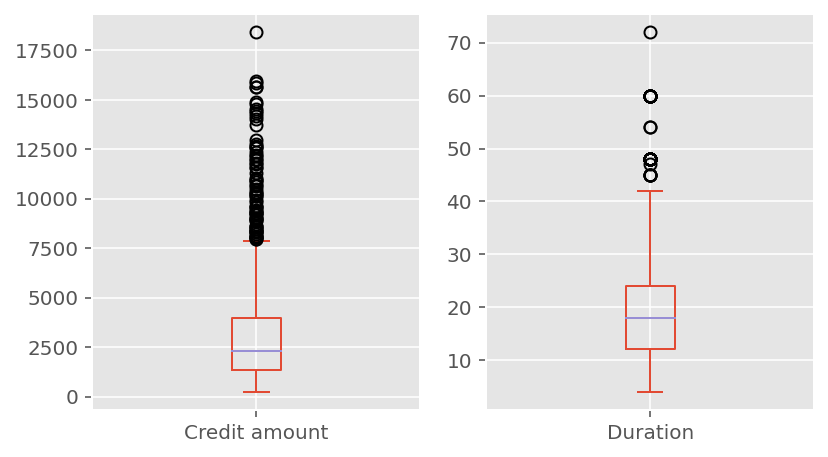

In [60]:
df[['Credit amount','Duration']].plot(kind= 'box' , subplots=True, layout=(2,3), sharex=False, sharey=False, figsize=(10,8));

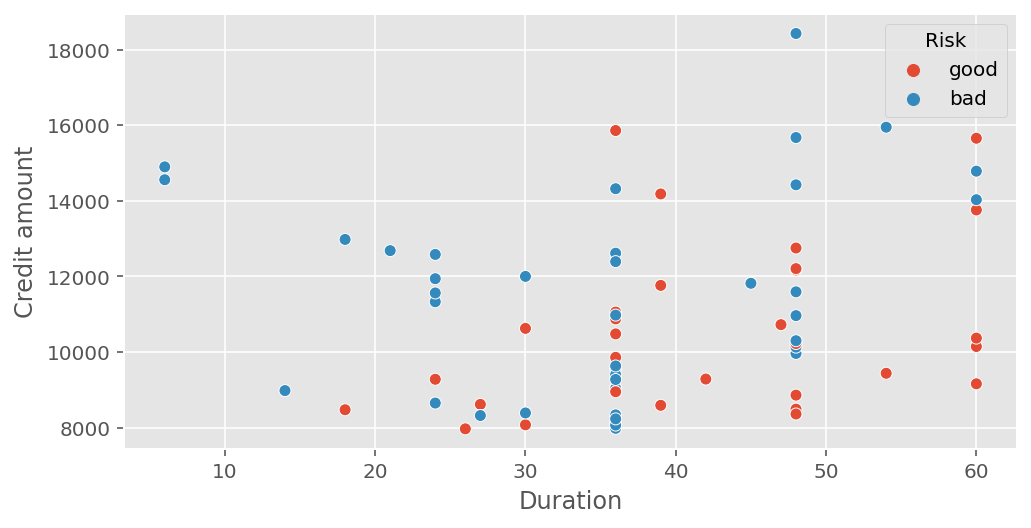

In [61]:
fig, ax = plt.subplots( figsize = (8,4))

sns.scatterplot(y = "Credit amount", x = "Duration",data=df[df["Credit amount"]>7900],hue='Risk')

plt.show()

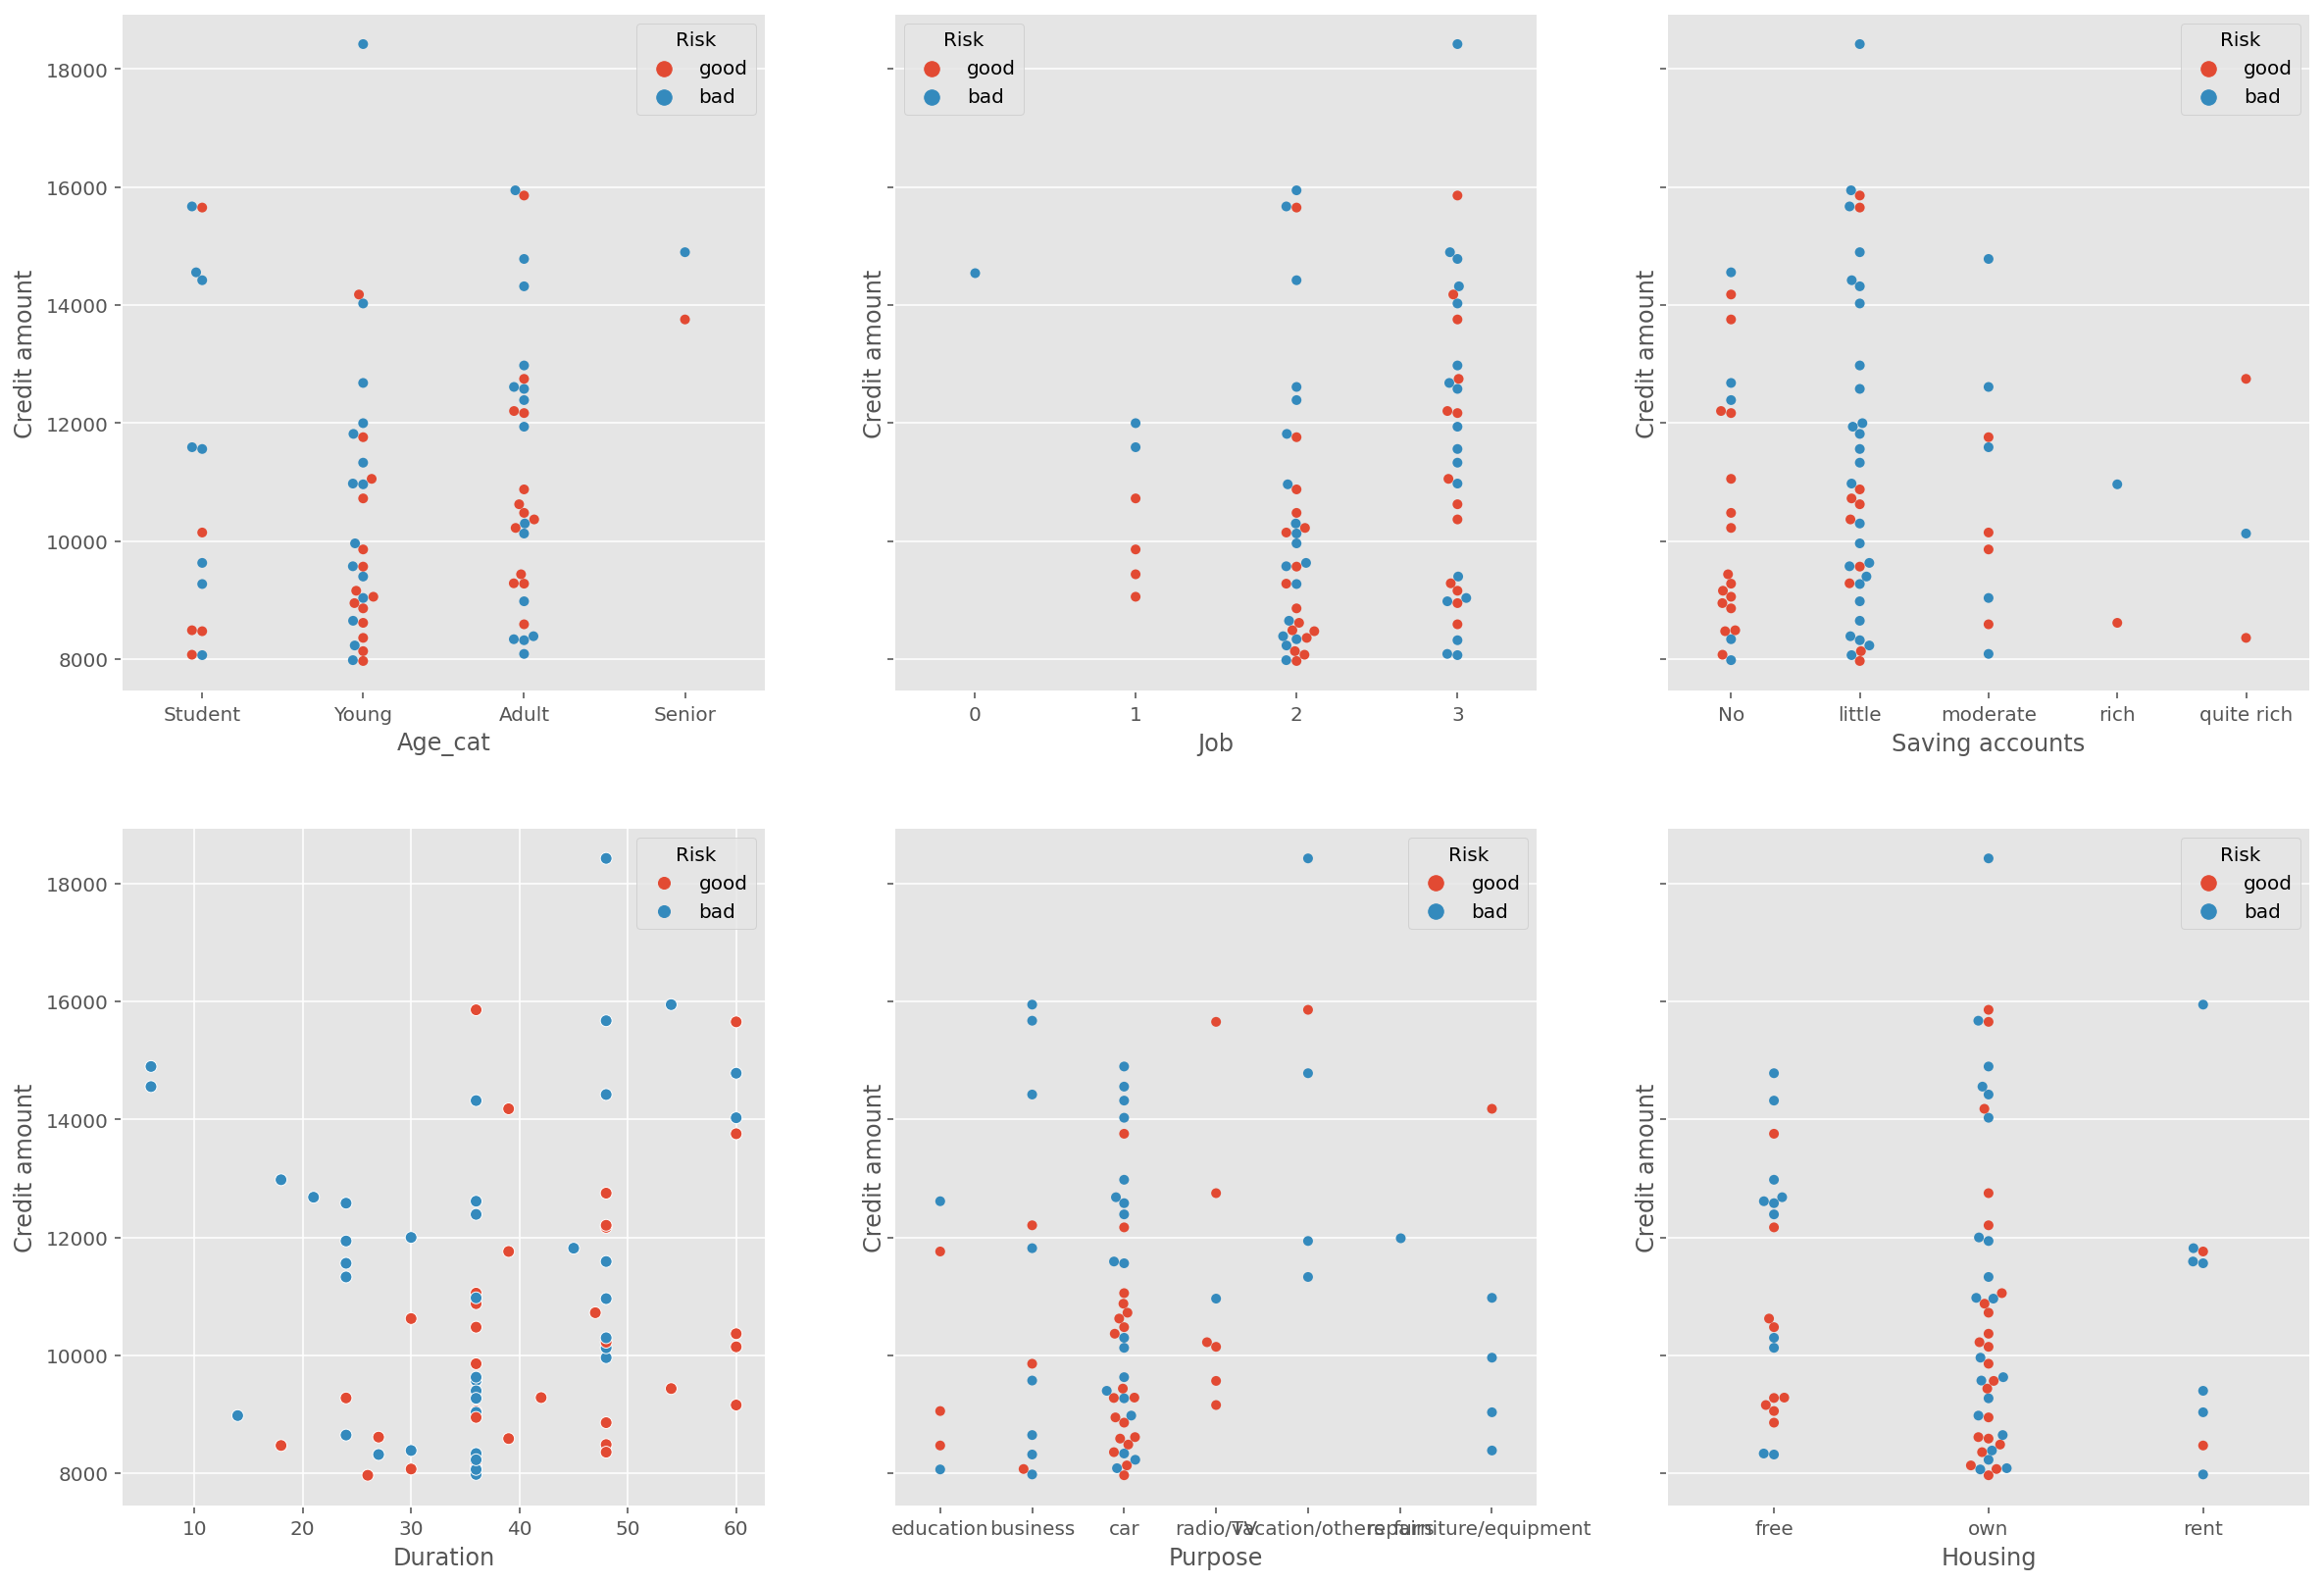

In [62]:
fig, ax = plt.subplots(2,3, figsize = (20,14),sharey=True)

sns.swarmplot(y = "Credit amount", x = "Age_cat",data=df[df["Credit amount"]>7900] ,ax = ax[0,0],hue='Risk')
sns.swarmplot(y = "Credit amount", x = "Job",data = df[df["Credit amount"]>7900], ax = ax[0,1],hue='Risk')

sns.scatterplot(y = "Credit amount", x = "Duration",data=df[df["Credit amount"]>7900] ,ax = ax[1,0],hue='Risk')
sns.swarmplot(y = "Credit amount", x = "Purpose",data = df[df["Credit amount"]>7900], ax = ax[1,1],hue='Risk')


sns.swarmplot(y = "Credit amount", x = "Housing",data = df[df["Credit amount"]>7900], ax = ax[1,2],hue='Risk')
sns.swarmplot(y = "Credit amount", x = "Saving accounts",data = df[df["Credit amount"]>7900], ax = ax[0,2],hue='Risk')


plt.show()

# Implementacion de Modelos de Clasificación

In [10]:
# No hay valores Nan
get_na(df)

,datos sin NAs en q,Na en q,Na en %
Sex,1000,0,0.0
Job,1000,0,0.0
Housing,1000,0,0.0
Saving accounts,1000,0,0.0
Checking account,1000,0,0.0
Credit amount,1000,0,0.0
Duration,1000,0,0.0
Purpose,1000,0,0.0
Risk,1000,0,0.0
Age_cat,1000,0,0.0


In [12]:
df.dtypes

Sex                   object
Job                    int64
Housing               object
Saving accounts       object
Checking account      object
Credit amount          int64
Duration               int64
Purpose               object
Risk                  object
Age_cat             category
dtype: object

In [11]:
# Transformo las variables objeto en categoricas para que pueda correr el modelo
df["Housing"] = df["Housing"].astype('category')
df["Saving accounts"] = df["Saving accounts"].astype('category')
df["Checking account"] = df["Checking account"].astype('category')
df["Purpose"] = df["Purpose"].astype('category')
df["Age_cat"] = df["Age_cat"].astype('category')
df["Risk"] = df["Risk"].astype('category')

In [12]:
# Genero el encoder

oe_style = OneHotEncoder() #Para variables que tienen dos valores unicos es mejor transformarlas a binarias
oe_results = oe_style.fit_transform(df[["Risk"]])
df[['good','bad']] = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
oe_results = oe_style.fit_transform(df[["Age_cat"]])
df[['Senior', 'Student', 'Adult', 'Young']] = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
oe_results = oe_style.fit_transform(df[["Housing"]])
df[['own', 'free', 'rent']] = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
oe_results = oe_style.fit_transform(df[["Saving accounts"]])
df[['No', 'little', 'quite rich', 'rich', 'moderate']] = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
oe_results = oe_style.fit_transform(df[["Checking account"]])
df[['little', 'moderate', 'No', 'rich']] = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
oe_results = oe_style.fit_transform(df[["Purpose"]])
df[['radio/TV', 'education', 'furniture/equipment', 'car', 'business',
       'domestic appliances', 'repairs', 'vacation/others']] = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)
oe_results = oe_style.fit_transform(df[["Job"]])

df[[2, 1, 3, 0]] = pd.DataFrame(oe_results.toarray(), columns=oe_style.categories_)


df.head(4)

,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Age_cat,...,furniture/equipment,car,business,domestic appliances,repairs,vacation/others,2,1,3,0
0,male,2,own,No,little,1169,6,radio/TV,good,Senior,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,female,2,own,little,moderate,5951,48,radio/TV,bad,Student,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,male,1,own,little,No,2096,12,education,good,Adult,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,male,2,free,little,little,7882,42,furniture/equipment,good,Adult,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
# Eliminamos las variables que quedaron de mas
X = df.drop(['Sex','Risk',"good","bad","Housing","Saving accounts",
            "Checking account","Purpose","Age_cat","Job"], axis=1) #Elimino de mi dataset la variable a predecir y las que estan de mas
y = df.good #Defino el Target


In [20]:
X.columns

Index([      'Credit amount',            'Duration',              'Senior',
                   'Student',               'Adult',               'Young',
                       'own',                'free',                'rent',
                        'No',              'little',          'quite rich',
                      'rich',            'moderate',            'radio/TV',
                 'education', 'furniture/equipment',                 'car',
                  'business', 'domestic appliances',             'repairs',
           'vacation/others',                     2,                     1,
                           3,                     0],
      dtype='object')

### Escalamiento de las variables

In [14]:
#Escalamos las variables para que queden en una misma unidad de medida

X.loc[:,'Credit amount']=MinMaxScaler().fit_transform(X[['Credit amount']])
X.loc[:,'Duration']=MinMaxScaler().fit_transform(X[['Duration']])


In [15]:
X.describe()

,Credit amount,Duration,Senior,Student,Adult,Young,own,free,rent,No,...,furniture/equipment,car,business,domestic appliances,repairs,vacation/others,2,1,3,0
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.0000,1000.000000,1000.000000
mean,0.166241,0.248574,0.367000,0.045000,0.190000,0.39800,0.108000,0.713000,0.179000,0.269000,...,0.01200,0.059000,0.181000,0.280000,0.022000,0.01200,0.022000,0.2000,0.630000,0.148000
std,0.155317,0.177336,0.482228,0.207408,0.392497,0.48973,0.310536,0.452588,0.383544,0.443662,...,0.10894,0.235743,0.385211,0.449224,0.146757,0.10894,0.146757,0.4002,0.483046,0.355278
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000
25%,0.061379,0.117647,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000
50%,0.113871,0.205882,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0000,1.000000,0.000000
75%,0.204812,0.294118,1.000000,0.000000,0.000000,1.00000,0.000000,1.000000,0.000000,1.000000,...,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.0000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.0000,1.000000,1.000000


In [16]:
# Separo el data set: 30% Test y 70% Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5,stratify=y)

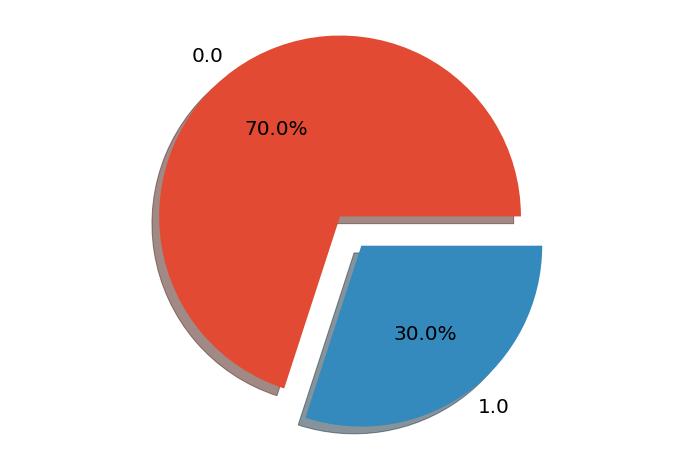

In [17]:
# La variable target esta desbalanceada
plot_pie(y_train)

#### Balanceo las clases

Información del dataset con Random Under Sampling:
 y: Counter({0.0: 300, 1.0: 300})


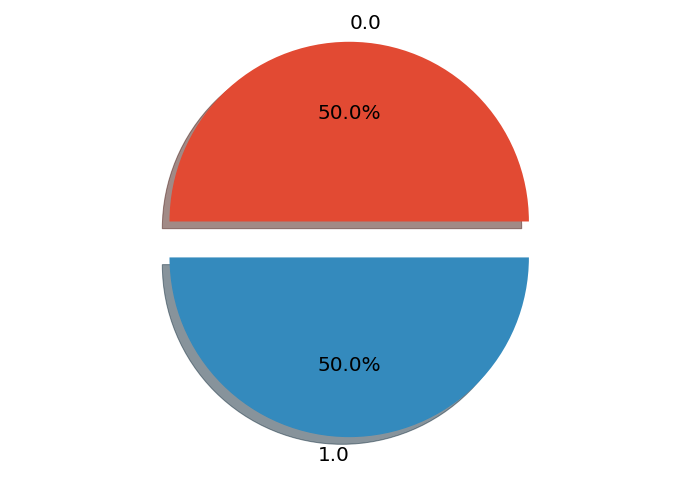

In [18]:
# El balanceo se puede hacer con under sampler o over sample
# Eligio under, ya que es el que menos valores sinteticos crea de los dos
undersample = RandomUnderSampler(
    sampling_strategy ='majority', random_state=0).fit(X_train, y_train)
X_train_us, y_train_us = undersample.fit_resample(X, y)
print('Información del dataset con Random Under Sampling:'
      '\n y: {}'.format(Counter(y_train_us)))
plot_pie(y_train_us)

# Planteo de los Modelos

- Por lo que observamos en el dataset, la mayoría de las variables son categóricas, y dentro de ellas muchas son binarias, incluyendo la variable a predecir: Risk. Es por ello que un arbol de decisiones, random forest, regresión logistica o LGBM surge como un modelo atractivo para intentar predecir si un cliente es riesgoso o no al tomar un crédito.

- Al realizar un escalamiento de la variables, estas quedan en una misma unidad de medida, podemos utilizar algoritmos que usan medidas de distancia como SVM.

# Planteo de las Métricas

Dos planteos de Métricas:

1. Al banco le resulta mas costoso otorgar créditos que erroneamente estimamos como de bajo riesgo, y que finalmente no lo sean (los falsos positivos).
2. Por otro lado, tambien consideramos una perdida de oportunidad ( y por lo tanto de dinero) subestimar los creditos no riesgosos , es decir, no darle la importancia suficiente a esa metrica. Sin embargo, concluimos que ante la necesidad de priorizar una, la primera metrica resulta mas ponderante en el negocio. 

Definimos que nos va a interesar la métrica de precisión y recall, por lo tanto vamos a utilizar el f1 por promedio ponderado que pondera ambas métricas teniendo en cuenta el peso de los créditos "Good" y "Bad".

## Árbol de Decisión

#### Búsqueda de los hiperparámetros óptimos para el árbol

In [19]:
# GridSearch
arbol = DecisionTreeClassifier() 
param_grid = {'max_depth': [2,5,10,20] , 'min_samples_leaf':[5,10,15,20]}
cv = KFold(n_splits=5)

grid = GridSearchCV(arbol, param_grid, cv=cv, scoring='f1')
grid.fit(X_train_us, y_train_us)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 15, 20]},
             scoring='f1')

In [20]:
best_max_depth = grid.best_params_['max_depth']
best_min_samples_leaf = grid.best_params_['min_samples_leaf']
print('La mejor profundidad es ' + str(best_max_depth) + ' y la mejor cantidad minima de muestras por hoja es ' + str(best_min_samples_leaf))

La mejor profundidad es 2 y la mejor cantidad minima de muestras por hoja es 5


In [21]:
# Random Search
param_dist = {'max_depth': [2,5,10,20] , 'min_samples_leaf':[5,10,15,20]}

#Aplicamos la grilla al modelo
model = RandomizedSearchCV(arbol, param_dist,n_iter=100, random_state=0, cv=5,scoring='f1')
model.fit(X_train_us, y_train_us)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions={'max_depth': [2, 5, 10, 20],
                                        'min_samples_leaf': [5, 10, 15, 20]},
                   random_state=0, scoring='f1')

In [22]:
best_max_depth = model.best_params_['max_depth']
best_min_samples_leaf = model.best_params_['min_samples_leaf']
print('La mejor profundidad es ' + str(best_max_depth) + ' y la mejor cantidad minima de muestras por hoja es ' + str(best_min_samples_leaf))

La mejor profundidad es 2 y la mejor cantidad minima de muestras por hoja es 15


Se obtiene el mismo resultado con los dos modelos de optimización

In [23]:
# Creamos el modelo
arbol_de_decision = DecisionTreeClassifier(max_depth=2, random_state = 5,min_samples_leaf=15) 
# Entrenamos el modelo con el 70% de los datos de entrenamiento
arbol_de_decision.fit(X_train_us,y_train_us) 
# Hago la prediccion con los datos de entrenamiento
prediccion = arbol_de_decision.predict(X_train)
print(classification_report(y_train,prediccion))

              precision    recall  f1-score   support

         0.0       0.87      0.61      0.72       490
         1.0       0.46      0.80      0.59       210

    accuracy                           0.66       700
   macro avg       0.67      0.70      0.65       700
weighted avg       0.75      0.66      0.68       700



In [24]:
# Hago la prediccion con la parte de los datos que defini como test, 30%
prediccion = arbol_de_decision.predict(X_test)
print(classification_report(y_test,prediccion))

# Bajan todas las metricas, esto es producto de overfitting del modelo en los datos de entrenamiento

              precision    recall  f1-score   support

         0.0       0.87      0.54      0.67       210
         1.0       0.43      0.81      0.56        90

    accuracy                           0.62       300
   macro avg       0.65      0.68      0.62       300
weighted avg       0.74      0.62      0.64       300



In [25]:
arbol_1 =round(f1_score(y_test,prediccion,average='weighted'),3)
arbol_1

0.637

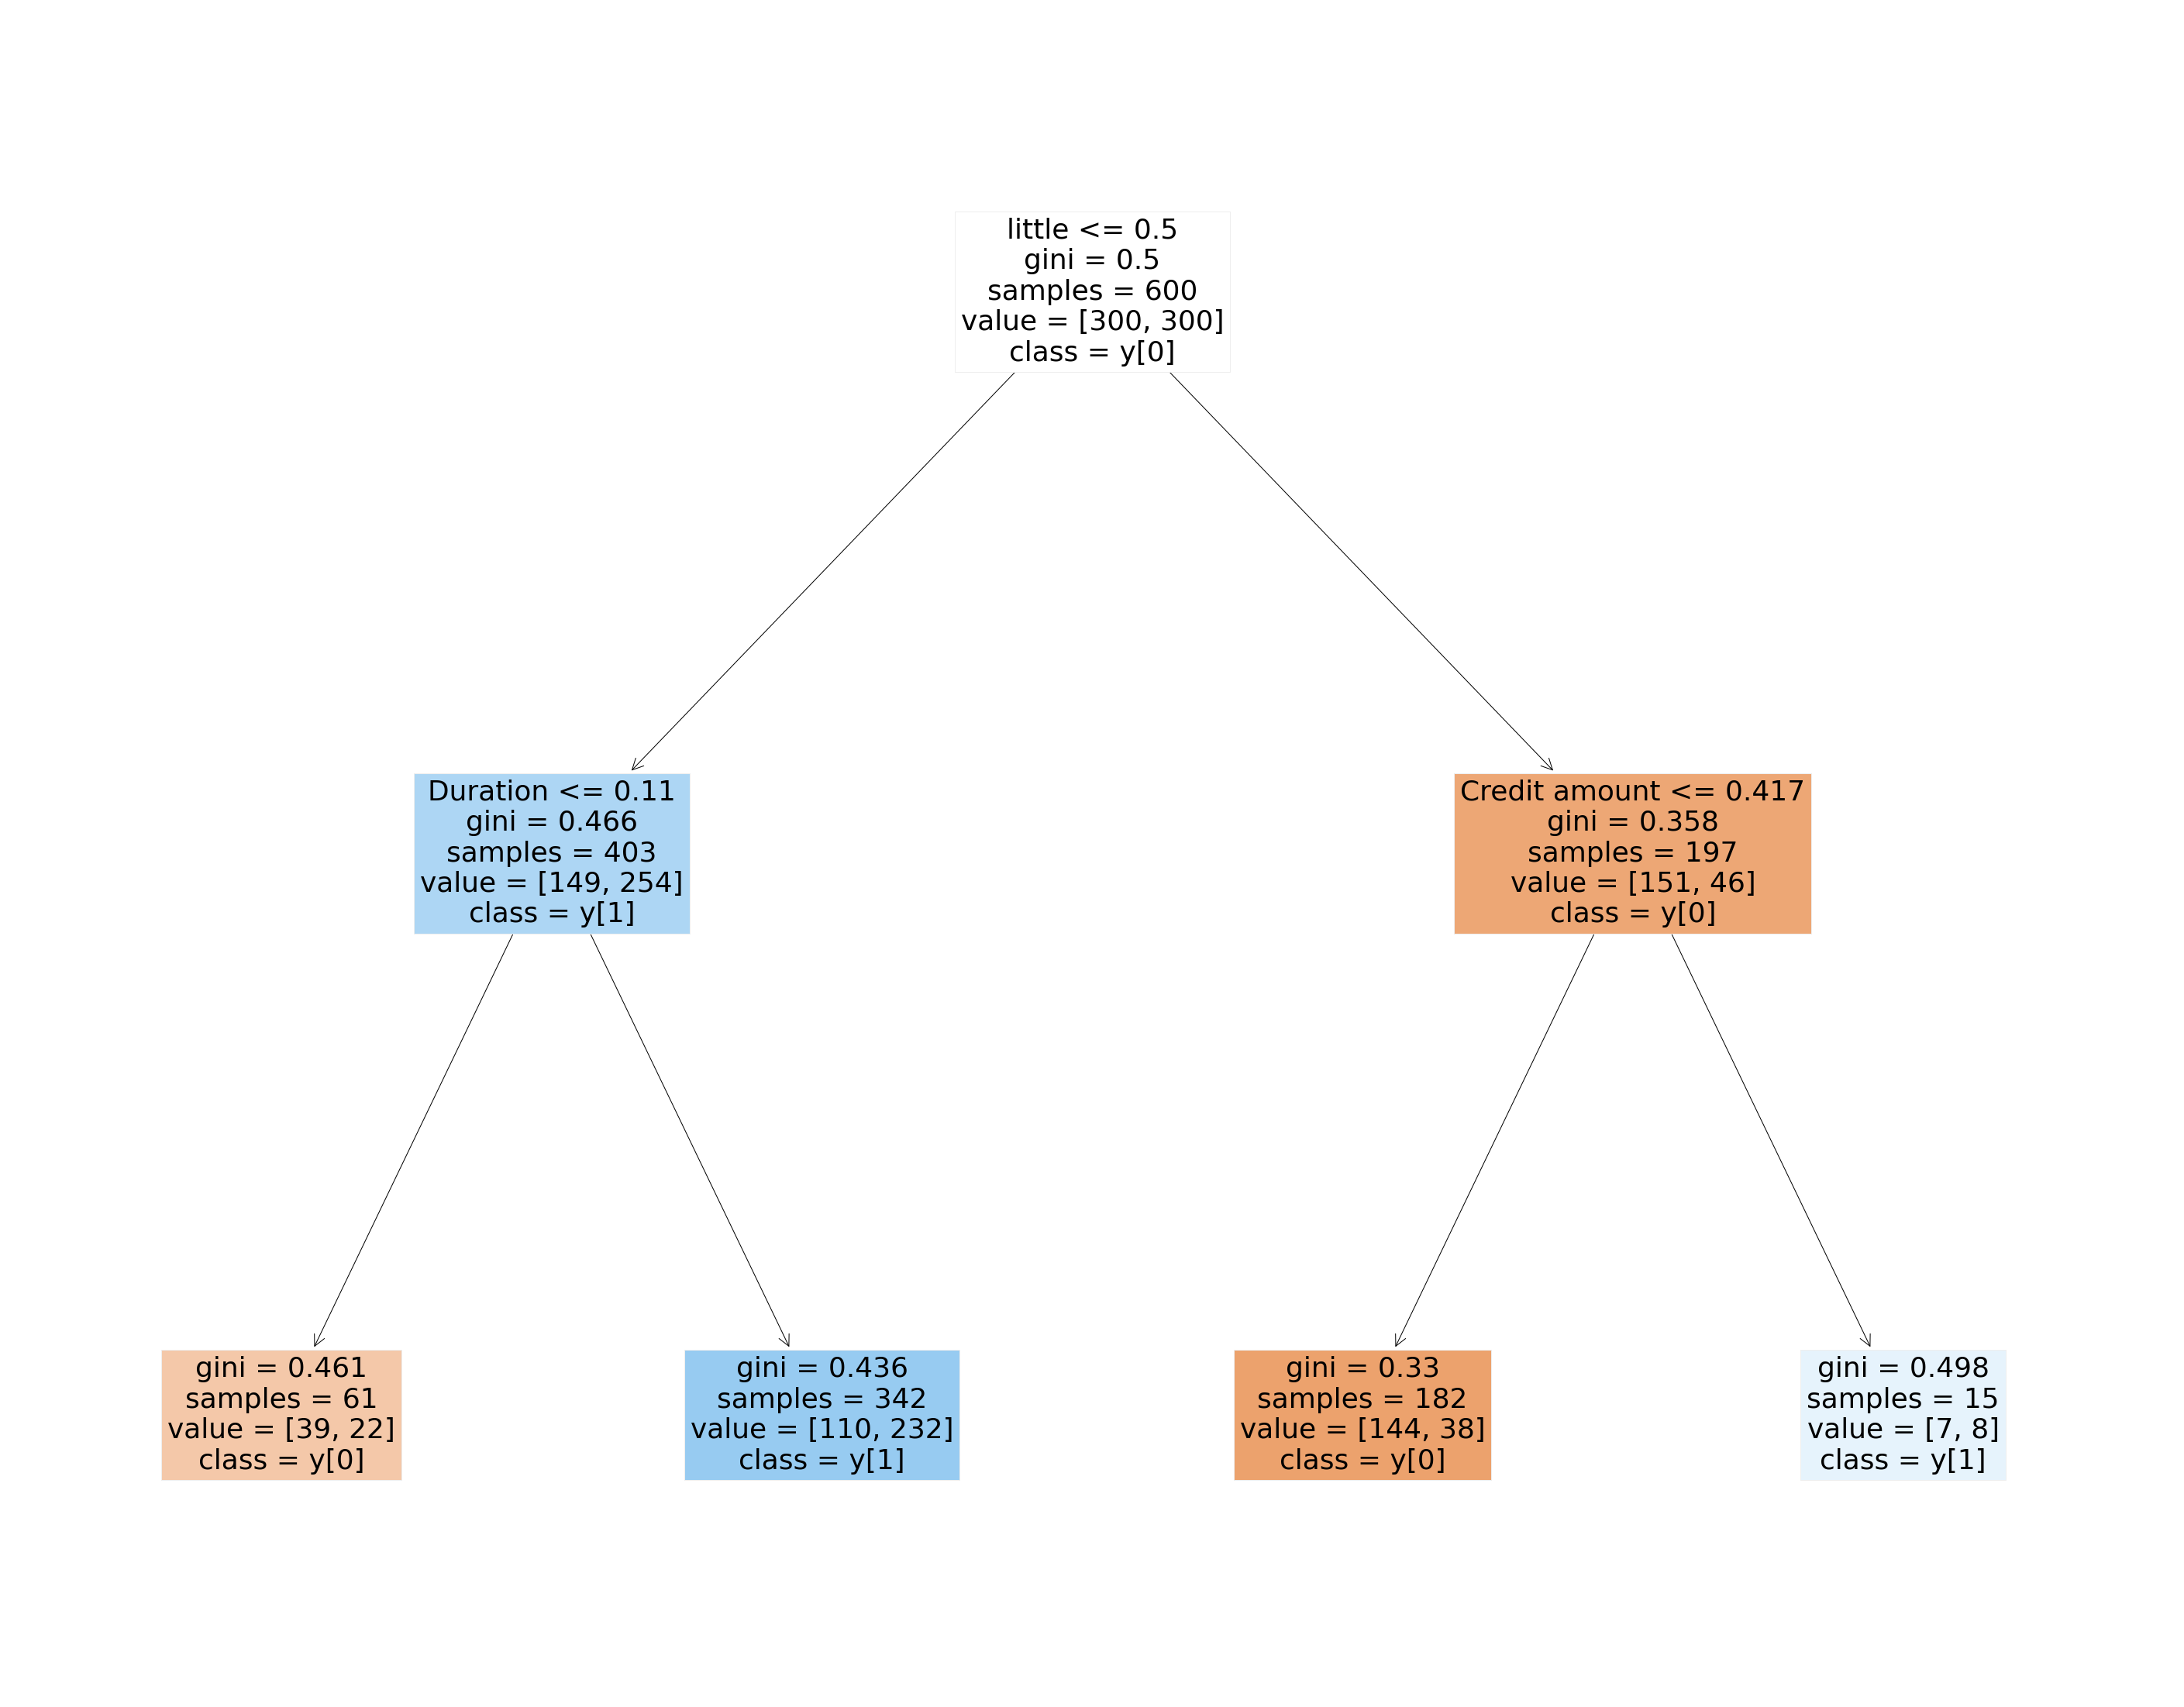

In [26]:
fig = plt.figure(figsize=(25,20))
plot = plot_tree(arbol_de_decision, feature_names=X.columns, filled=True, fontsize=18, class_names=True)

In [27]:
# Al contruir el modelo con los datos de entrenamiento, predigo con los datos del X test y armo la matriz de confusión 
# comparandolo con Y test
prediccion = arbol_de_decision.predict(X_test)
pd.crosstab(y_test,prediccion,rownames=['Actual class'], colnames=['Predicted class'])

Predicted class,0.0,1.0
Actual class,,
0.0,114,96
1.0,17,73


# Random Forest

In [28]:
# Separo el data set: 30% Test y 70% Train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5)

Información del dataset con Random Under Sampling:
 y: Counter({0.0: 300, 1.0: 300})


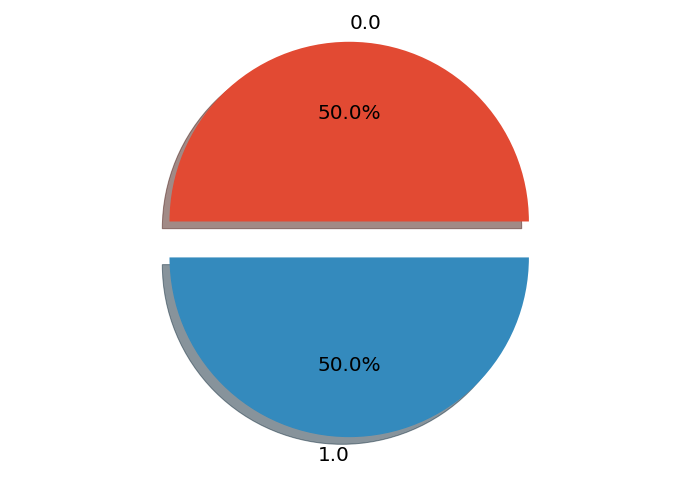

In [29]:
# El balanceo se puede hacer con under sampler o over sample
# Eligio under, ya que es el que menos valores sinteticos crea de los dos
undersample = RandomUnderSampler(
    sampling_strategy ='majority', random_state=0).fit(X_train, y_train)
X_train_us, y_train_us = undersample.fit_resample(X, y)
print('Información del dataset con Random Under Sampling:'
      '\n y: {}'.format(Counter(y_train_us)))
plot_pie(y_train_us)

#### Búsqueda de los hiperparámetros óptimos

In [30]:
#RandomizedSearchCV

grid_params = {"n_estimators":[300,500] , "max_features": ['sqrt', 'log2'], "max_samples": [0.50,0.8], "max_depth": [4,10], 
               "min_samples_leaf":[4,8]}

In [31]:
# Modelo
clf = RandomForestClassifier()
# Aca se define el metodo para separar los datos, puede ser Cross Validation

model = GridSearchCV(estimator=clf,param_grid=grid_params, cv=5,scoring='f1')
model.fit(X_train_us, y_train_us)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 10], 'max_features': ['sqrt', 'log2'],
                         'max_samples': [0.5, 0.8], 'min_samples_leaf': [4, 8],
                         'n_estimators': [300, 500]},
             scoring='f1')

In [32]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'max_depth': 10, 'max_features': 'log2', 'max_samples': 0.5, 'min_samples_leaf': 4, 'n_estimators': 300}
Mejor Score: 0.7290010424102358



In [36]:
# Creo el modelo
clf = RandomForestClassifier(random_state=5, n_estimators=model.best_params_["n_estimators"],max_features=model.best_params_["max_features"],
                             max_samples=model.best_params_["max_samples"],max_depth=model.best_params_["max_depth"],
                             min_samples_leaf=model.best_params_["min_samples_leaf"])
# Entreno el modelo con los datos balanceados
clf.fit(X_train_us, y_train_us)
# Hago la prediccion con los datos de entrenamiento
prediccion = clf.predict(X_train)
print(classification_report(y_train,prediccion))

              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78       482
         1.0       0.54      0.80      0.65       218

    accuracy                           0.73       700
   macro avg       0.71      0.75      0.71       700
weighted avg       0.78      0.73      0.74       700



In [37]:
# Hago la prediccion con los datos de test
prediccion = clf.predict(X_test)
print(classification_report(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.89      0.70      0.78       218
         1.0       0.49      0.77      0.60        82

    accuracy                           0.72       300
   macro avg       0.69      0.74      0.69       300
weighted avg       0.78      0.72      0.73       300



In [38]:
clf_2 = round(f1_score(y_test,prediccion,average='weighted'),3)
clf_2

0.734

## Regresión Logística

### Búsqueda de los hiperparámetros óptimos para la regresión

In [39]:
regresion_logistica = LogisticRegression()

In [40]:
# Random Search
param_grid = {'solver' : ['lbfgs', 'liblinear'], 'penalty' : ['l2']}


#Aplicamos la grilla al modelo
model = RandomizedSearchCV(estimator=regresion_logistica,param_distributions= param_grid,n_iter=100, random_state=0, cv=5,scoring='f1')
model.fit(X_train_us, y_train_us)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=100,
                   param_distributions={'penalty': ['l2'],
                                        'solver': ['lbfgs', 'liblinear']},
                   random_state=0, scoring='f1')

In [41]:
print("Mejores parametros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores parametros: {'solver': 'liblinear', 'penalty': 'l2'}
Mejor Score: 0.6983468016724154



In [42]:
regresion_logistica = LogisticRegression(random_state=5,solver=model.best_params_["solver"],penalty=model.best_params_["penalty"])
regresion_logistica.fit(X_train_us, y_train_us)
prediccion = regresion_logistica.predict(X_train)
print(classification_report(y_train,prediccion))

              precision    recall  f1-score   support

         0.0       0.85      0.63      0.73       482
         1.0       0.48      0.76      0.59       218

    accuracy                           0.67       700
   macro avg       0.67      0.70      0.66       700
weighted avg       0.74      0.67      0.68       700



In [43]:
# Hago la prediccion con los datos de test
prediccion = regresion_logistica.predict(X_test)
print(classification_report(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.87      0.65      0.75       218
         1.0       0.45      0.74      0.56        82

    accuracy                           0.68       300
   macro avg       0.66      0.70      0.65       300
weighted avg       0.75      0.68      0.69       300



In [44]:
rl_1 = round(f1_score(y_test,prediccion,average='weighted'),3)
rl_1

0.694

## Super Vector Machine

### Búsqueda de los hiperparámetros óptimos para la regresión

In [45]:
SVM = SVC(gamma = "auto")

In [46]:
# Random Search
param = {'kernel' : ['poly', 'rbf', 'sigmoid'], 'C' : [50, 10, 1.0, 0.1, 0.01], "gamma" : ['scale']}


#Aplicamos la grilla al modelo
model = RandomizedSearchCV(estimator=SVM, param_distributions= param,n_iter=100, random_state=0, cv=5,scoring='f1')
model.fit(X_train_us, y_train_us)

RandomizedSearchCV(cv=5, estimator=SVC(gamma='auto'), n_iter=100,
                   param_distributions={'C': [50, 10, 1.0, 0.1, 0.01],
                                        'gamma': ['scale'],
                                        'kernel': ['poly', 'rbf', 'sigmoid']},
                   random_state=0, scoring='f1')

In [47]:
print("Mejores Parámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores Parámetros: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.01}
Mejor Score: 0.7314905331449995



In [48]:
SVM = SVC(random_state=5,kernel=model.best_params_["kernel"],C=model.best_params_["C"],gamma=model.best_params_["gamma"])
SVM.fit(X_train_us, y_train_us)
prediccion = SVM.predict(X_train)
print(classification_report(y_train,prediccion))

              precision    recall  f1-score   support

         0.0       0.89      0.50      0.64       482
         1.0       0.44      0.86      0.58       218

    accuracy                           0.61       700
   macro avg       0.66      0.68      0.61       700
weighted avg       0.75      0.61      0.62       700



In [49]:
# Hago la prediccion con los datos de test
prediccion = SVM.predict(X_test)
print(classification_report(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.90      0.54      0.68       218
         1.0       0.41      0.84      0.55        82

    accuracy                           0.62       300
   macro avg       0.65      0.69      0.61       300
weighted avg       0.77      0.62      0.64       300



In [50]:
svm = round(f1_score(y_test,prediccion,average='weighted'),3)
svm

0.642

## Light Gradient Boosting Machine

### Búsqueda de los hiperparámetros óptimos para la regresión

In [51]:
LGBM = lgb.LGBMClassifier()

In [52]:
# Random Search
param = {'class_weight' : [None,'balanced'], 'boosting_type' : ['gbdt', 'goss', 'dart'], "num_leaves" : [15,30,50,100,150,200,300], 
         "application":["binary","multiclass "],"learning_rate": list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10))}


#Aplicamos la grilla al modelo
model = RandomizedSearchCV(estimator=LGBM, param_distributions= param,n_iter=100, random_state=0, cv=5,scoring='f1')
model.fit(X_train_us, y_train_us)

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=100,
                   param_distributions={'application': ['binary',
                                                        'multiclass '],
                                        'boosting_type': ['gbdt', 'goss',
                                                          'dart'],
                                        'class_weight': [None, 'balanced'],
                                        'learning_rate': [0.005000000000000004,
                                                          0.007533150951473343,
                                                          0.01134967265153673,
                                                          0.01709975946676697,
                                                          0.02576301385940817,
                                                          0.03881533447356429,
                                                          0.05848035476425732,
                                                          0.08810826802697265,
                                                          0.1327465766240114,
                                                          0.20000000000000004],
                                        'num_leaves': [15, 30, 50, 100, 150,
                                                       200, 300]},
                   random_state=0, scoring='f1')

In [53]:
print("Mejores Parámetros: "+str(model.best_params_))
print("Mejor Score: "+str(model.best_score_)+'\n')

Mejores Parámetros: {'num_leaves': 15, 'learning_rate': 0.01709975946676697, 'class_weight': 'balanced', 'boosting_type': 'goss', 'application': 'binary'}
Mejor Score: 0.6907929013785216



In [54]:
LGBM = lgb.LGBMClassifier(random_state=5, application=model.best_params_["application"], learning_rate=model.best_params_["learning_rate"],
            class_weight=model.best_params_["class_weight"], boosting_type=model.best_params_["boosting_type"], num_leaves=model.best_params_["num_leaves"])
LGBM.fit(X_train_us, y_train_us)
prediccion = LGBM.predict(X_train)
print(classification_report(y_train,prediccion))

              precision    recall  f1-score   support

         0.0       0.88      0.72      0.79       482
         1.0       0.56      0.78      0.65       218

    accuracy                           0.74       700
   macro avg       0.72      0.75      0.72       700
weighted avg       0.78      0.74      0.75       700



In [72]:
# Hago la prediccion con los datos de test
prediccion = LGBM.predict(X_test)
print(classification_report(y_test,prediccion))

              precision    recall  f1-score   support

         0.0       0.87      0.73      0.80       218
         1.0       0.50      0.72      0.59        82

    accuracy                           0.73       300
   macro avg       0.69      0.73      0.70       300
weighted avg       0.77      0.73      0.74       300



In [71]:
lgbm_1 = round(f1_score(y_test,prediccion,average='weighted'),3)
lgbm_1

0.742

# Resultados

In [57]:
d = {'Árbol de Decisión': [arbol_1],'Random Forest': [clf_2],'Regresion Logística': [rl_1],'SVM': [svm],'LGBM': [lgbm_1]}
pd.DataFrame(data=d,index=['f1-Score'])

,Árbol de Decisión,Random Forest,Regresion Logística,SVM,LGBM
f1-Score,0.637,0.734,0.694,0.642,0.742


El modelo que mejor performance es LGBM

## Evaluacion del modelo seleccionado e importancia de cada Feature

- Good = 0
- Bad = 1

In [70]:
# Matriz de Confusión
prediccion = LGBM.predict(X_test)
pd.crosstab(y_test,prediccion,rownames=['Actual class'], colnames=['Predicted class'])

Predicted class,0.0,1.0
Actual class,,
0.0,160,58
1.0,23,59


- De 218 créditos que estimo que son "good", 160 son correctos (73%) y 58 no lo son (los falsos positivos) 
- De 82 créditos que predigo que son "bad", 59 son correctos (72%) y 23 no lo son (los falsos negativos).

Desde el punto de vista del negocio la primer métrica me permite obtener una ganancia al estimar correctamente los créditos de riesgo "good"
y la segunda métrica me permite anticiparme a un crédito "bad" y no otorgarlo, ya que me generaría una futura pérdida

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot()
plt.show()

df_metrics

[Text(0, 0, 'car'),
 Text(1, 0, 'repairs'),
 Text(2, 0, '2'),
 Text(3, 0, 'Student'),
 Text(4, 0, 'vacation/others'),
 Text(5, 0, 'own'),
 Text(6, 0, 'furniture/equipment'),
 Text(7, 0, 'quite rich'),
 Text(8, 0, 'rent'),
 Text(9, 0, '0'),
 Text(10, 0, '1'),
 Text(11, 0, 'radio/TV'),
 Text(12, 0, 'education'),
 Text(13, 0, 'No'),
 Text(14, 0, 'free'),
 Text(15, 0, 'business'),
 Text(16, 0, 'Young'),
 Text(17, 0, 'Adult'),
 Text(18, 0, 'rich'),
 Text(19, 0, 'moderate'),
 Text(20, 0, 'domestic appliances'),
 Text(21, 0, '3'),
 Text(22, 0, 'Senior'),
 Text(23, 0, 'little'),
 Text(24, 0, 'Duration'),
 Text(25, 0, 'Credit amount')]

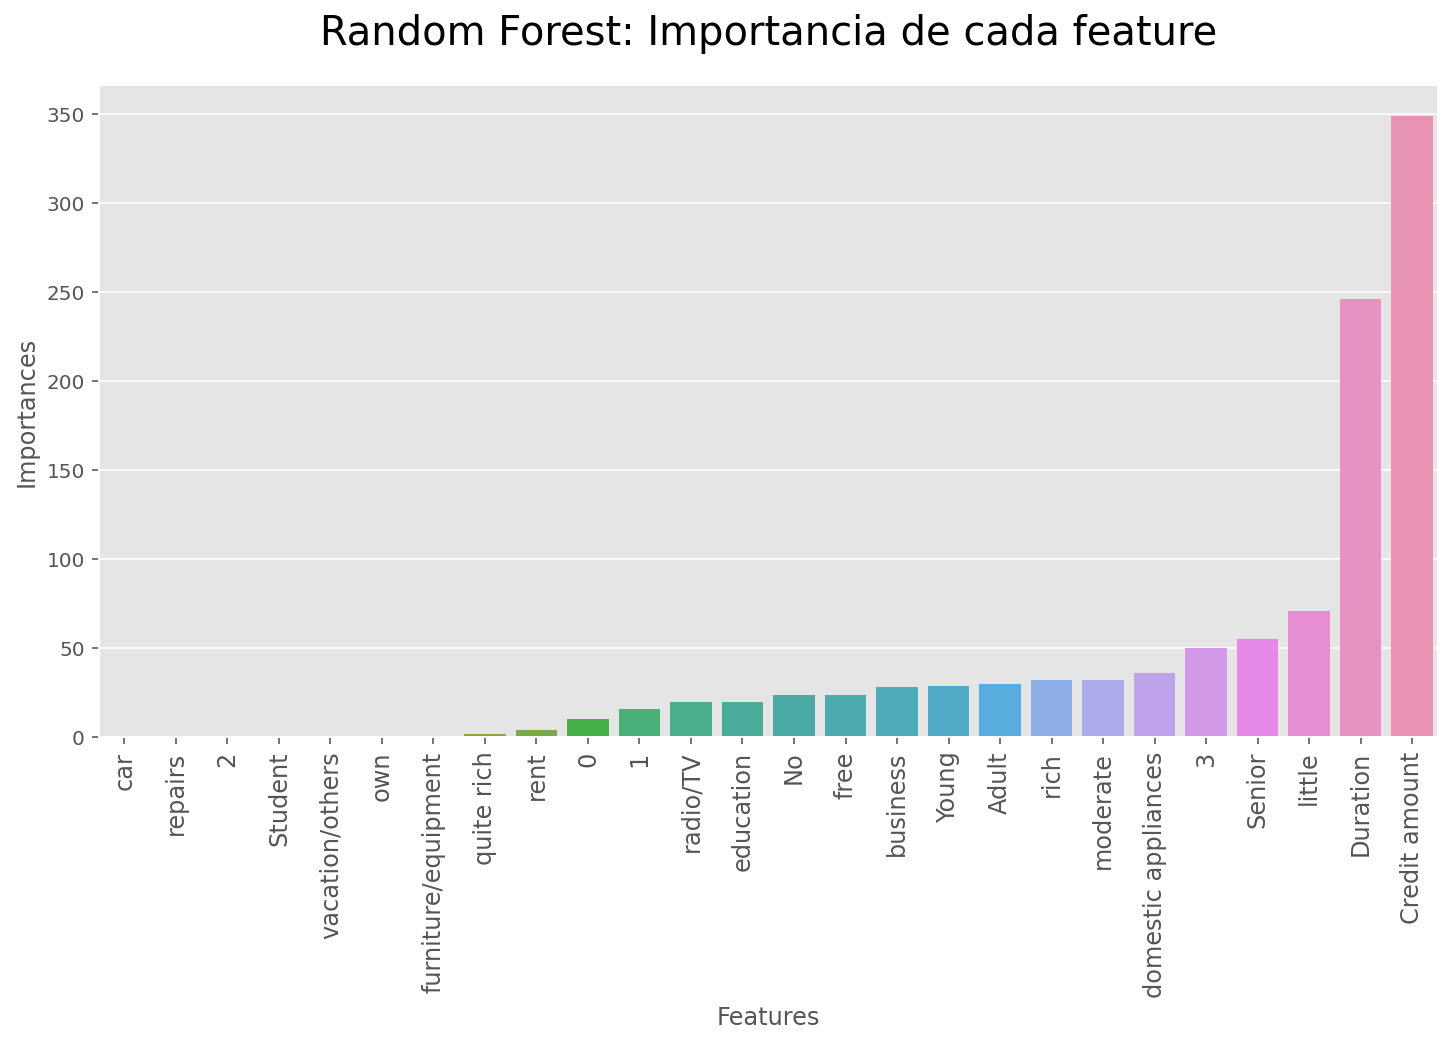

In [59]:
df_feat = pd.DataFrame()
df_feat["Features"] = X.columns
df_feat["Importances"] = LGBM.feature_importances_
df_feat.sort_values(["Importances"], inplace=True)

fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)

bp = sns.barplot(x=df_feat["Features"], y=df_feat["Importances"])
bp.axes.set_title("Random Forest: Importancia de cada feature",fontsize=20, pad=20)
bp.set_xticklabels(bp.get_xticklabels(),rotation = 90, fontsize=12)

# Conclusión

- Se desarrollaron diferentes modelos de Machine Learning y con el que mejores resultados se obtuvieron fue el Radom Forest capaz de clasificar a los clientes del banco e identificar cuales eran riesgosos y cuales no.
- Se elimino el overfitting, de esta manera el modelo seleccionado identifica el patron que hay en el data set y tiene la capacidad de predecir ante valores no conocidos.